In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from haversine import haversine
import xgboost
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
%matplotlib inline 

In [2]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [3]:
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
test.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   
4  1465         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub  ...         120        0    NaN  MnPrv         NaN   
1         Lvl    AllPub  ...           0        0    NaN    NaN        Gar2   
2         Lvl    AllPub  ...           0        0    NaN  MnPrv         NaN   
3         Lvl    AllPub  ...           0        0    NaN    NaN         NaN   
4         HLS    AllPub  ...         144        0    NaN    NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  
0       0      6    2010        WD         Normal  
1   12500      6    2010        WD         Normal  
2       0      3    2010        WD         Normal  
3       0      6    2010        WD         Normal  
4       0      1    2010        WD         Normal  

[5 rows x 80 columns]

In [4]:
submission = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')
submission

Id      SalePrice
0     1461  169277.052498
1     1462  187758.393989
2     1463  183583.683570
3     1464  179317.477511
4     1465  150730.079977
...    ...            ...
1454  2915  167081.220949
1455  2916  164788.778231
1456  2917  219222.423400
1457  2918  184924.279659
1458  2919  187741.866657

[1459 rows x 2 columns]

# Exploratory data analysis

In [5]:
train.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [6]:
train.describe(include=['int64'])

Id   MSSubClass        LotArea  OverallQual  OverallCond  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean    730.500000    56.897260   10516.828082     6.099315     5.575342   
std     421.610009    42.300571    9981.264932     1.382997     1.112799   
min       1.000000    20.000000    1300.000000     1.000000     1.000000   
25%     365.750000    20.000000    7553.500000     5.000000     5.000000   
50%     730.500000    50.000000    9478.500000     6.000000     5.000000   
75%    1095.250000    70.000000   11601.500000     7.000000     6.000000   
max    1460.000000   190.000000  215245.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   BsmtFinSF1   BsmtFinSF2    BsmtUnfSF  ...  \
count  1460.000000   1460.000000  1460.000000  1460.000000  1460.000000  ...   
mean   1971.267808   1984.865753   443.639726    46.549315   567.240411  ...   
std      30.202904     20.645407   456.098091   161.319273   441.866955  ...   
min    1872.000000   1950.000000     0.000000     0.000000     0.000000  ...   
25%    1954.000000   1967.000000     0.000000     0.000000   223.000000  ...   
50%    1973.000000   1994.000000   383.500000     0.000000   477.500000  ...   
75%    2000.000000   2004.000000   712.250000     0.000000   808.000000  ...   
max    2010.000000   2010.000000  5644.000000  1474.000000  2336.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean     94.244521    46.660274      21.954110     3.409589    15.060959   
std     125.338794    66.256028      61.119149    29.317331    55.757415   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    25.000000       0.000000     0.000000     0.000000   
75%     168.000000    68.000000       0.000000     0.000000     0.000000   
max     857.000000   547.000000     552.000000   508.000000   480.000000   

          PoolArea       MiscVal       MoSold       YrSold      SalePrice  
count  1460.000000   1460.000000  1460.000000  1460.000000    1460.000000  
mean      2.758904     43.489041     6.321918  2007.815753  180921.195890  
std      40.177307    496.123024     2.703626     1.328095   79442.502883  
min       0.000000      0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000      0.000000     5.000000  2007.000000  129975.000000  
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     738.000000  15500.000000    12.000000  2010.000000  755000.000000  

[8 rows x 35 columns]

In [7]:
train.describe(include=['float64']).T

count         mean         std     min     25%     50%     75%  \
LotFrontage  1201.0    70.049958   24.284752    21.0    59.0    69.0    80.0   
MasVnrArea   1452.0   103.685262  181.066207     0.0     0.0     0.0   166.0   
GarageYrBlt  1379.0  1978.506164   24.689725  1900.0  1961.0  1980.0  2002.0   

                max  
LotFrontage   313.0  
MasVnrArea   1600.0  
GarageYrBlt  2010.0

In [8]:
train.describe(include=['object'])

MSZoning Street Alley LotShape LandContour Utilities LotConfig  \
count      1460   1460    91     1460        1460      1460      1460   
unique        5      2     2        4           4         2         5   
top          RL   Pave  Grvl      Reg         Lvl    AllPub    Inside   
freq       1151   1454    50      925        1311      1459      1052   

       LandSlope Neighborhood Condition1  ... GarageType GarageFinish  \
count       1460         1460       1460  ...       1379         1379   
unique         3           25          9  ...          6            3   
top          Gtl        NAmes       Norm  ...     Attchd          Unf   
freq        1382          225       1260  ...        870          605   

       GarageQual GarageCond PavedDrive PoolQC  Fence MiscFeature SaleType  \
count        1379       1379       1460      7    281          54     1460   
unique          5          5          3      3      4           4        9   
top            TA         TA          Y     Gd  MnPrv        Shed       WD   
freq         1311       1326       1340      3    157          49     1267   

       SaleCondition  
count           1460  
unique             6  
top           Normal  
freq            1198  

[4 rows x 43 columns]

In [9]:
avg_stroke = train["SalePrice"].astype("float").mean(axis = 0)
print("Averge of Sale Price:", avg_stroke)

Averge of Sale Price: 180921.19589041095


In [10]:
train["SalePrice"].replace(np.nan, avg_stroke, inplace = True)
train["SalePrice"]

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

## Probability Plot 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


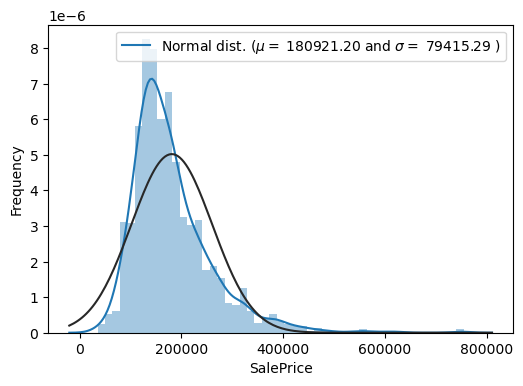

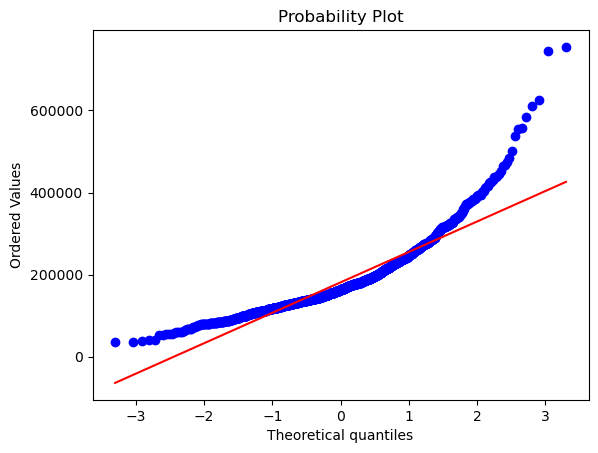

In [11]:
plt.subplots(figsize=(6,4))
sns.distplot(train['SalePrice'], fit=stats.norm)

(mu, sigma) = stats.norm.fit(train['SalePrice'])

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')

fig = plt.figure()
stats.probplot(train['SalePrice'], plot=plt)
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  after removing the cwd from sys.path.


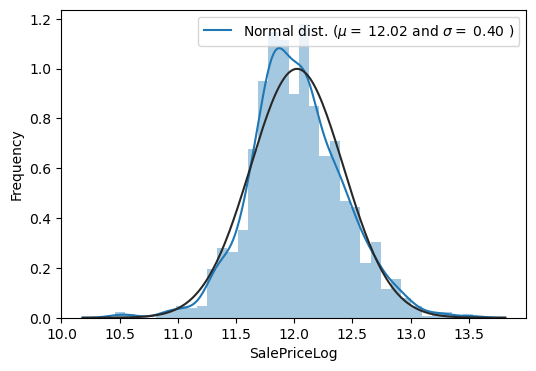

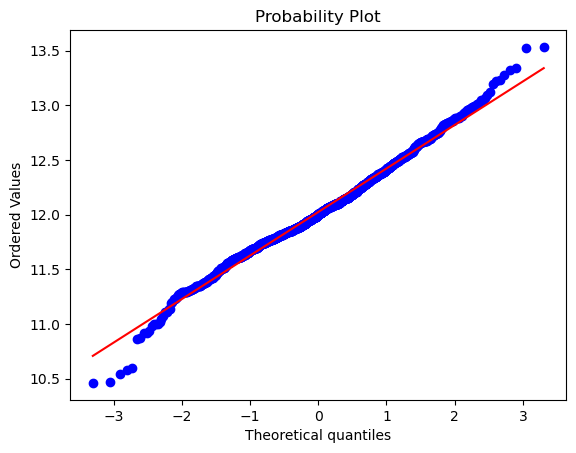

In [12]:
train['SalePriceLog'] = np.log1p(train['SalePrice'])

plt.subplots(figsize=(6,4))
sns.distplot(train['SalePriceLog'], fit=stats.norm)

(mu, sigma) = stats.norm.fit(train['SalePriceLog'])

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
fig = plt.figure()
stats.probplot(train['SalePriceLog'], plot=plt)
plt.show()

In [13]:
del train['SalePriceLog']

In [14]:
numeric_features = train.select_dtypes(include=[np.number])
numeric_features.head()

Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0   1          60         65.0     8450            7            5       2003   
1   2          20         80.0     9600            6            8       1976   
2   3          60         68.0    11250            7            5       2001   
3   4          70         60.0     9550            7            5       1915   
4   5          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  WoodDeckSF  OpenPorchSF  \
0          2003       196.0         706  ...           0           61   
1          1976         0.0         978  ...         298            0   
2          2002       162.0         486  ...           0           42   
3          1970         0.0         216  ...           0           35   
4          2000       350.0         655  ...         192           84   

   EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  MoSold  YrSold  \
0              0          0            0         0        0       2    2008   
1              0          0            0         0        0       5    2007   
2              0          0            0         0        0       9    2008   
3            272          0            0         0        0       2    2006   
4              0          0            0         0        0      12    2008   

   SalePrice  
0     208500  
1     181500  
2     223500  
3     140000  
4     250000  

[5 rows x 38 columns]

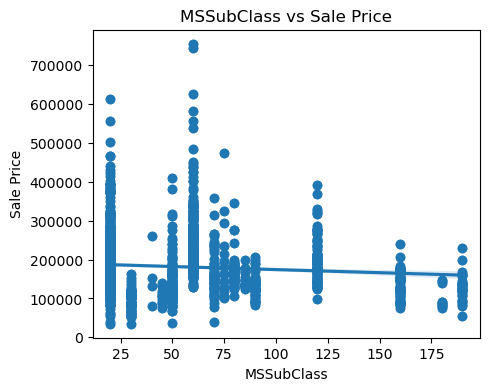

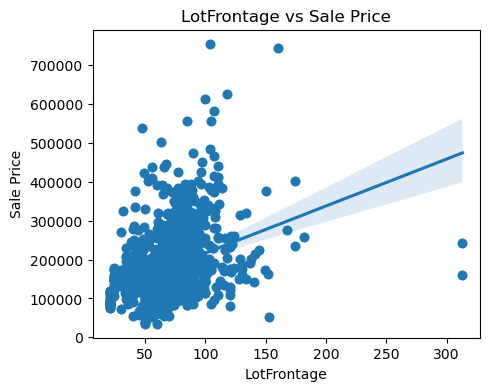

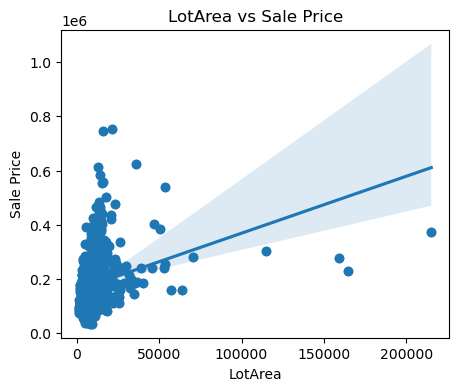

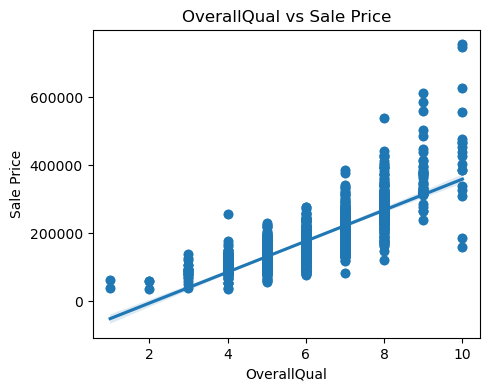

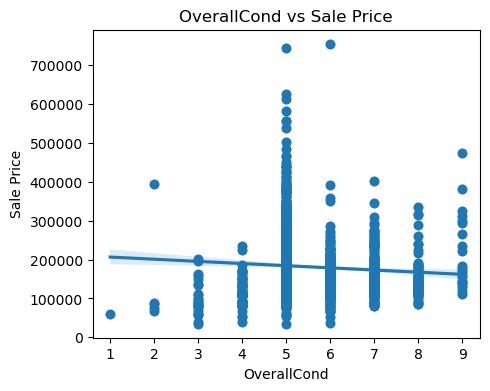

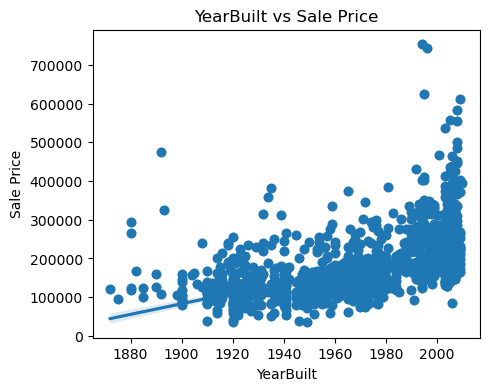

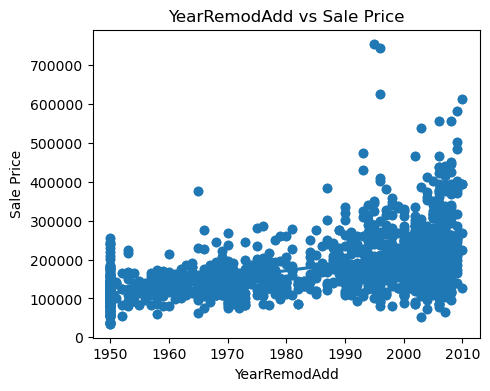

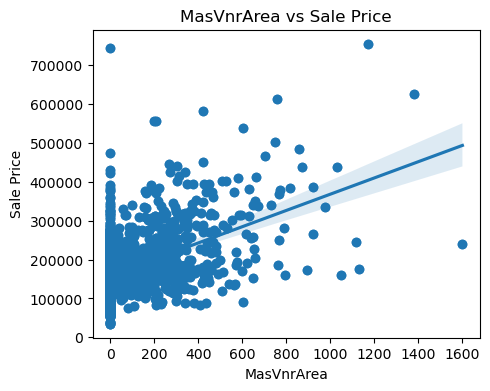

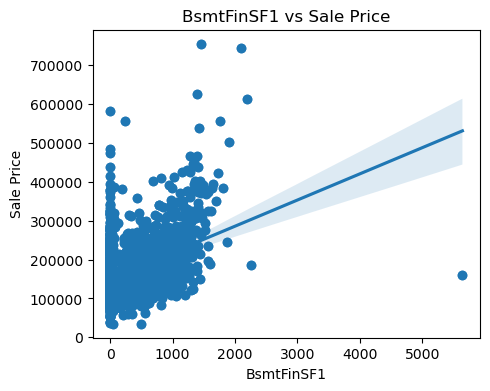

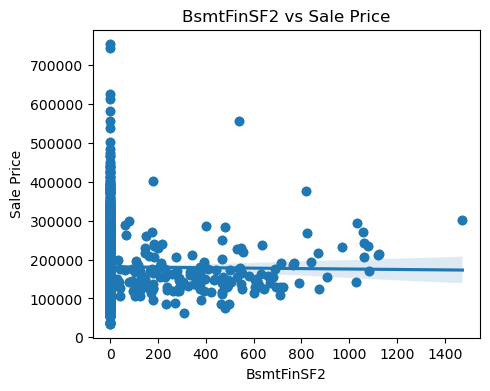

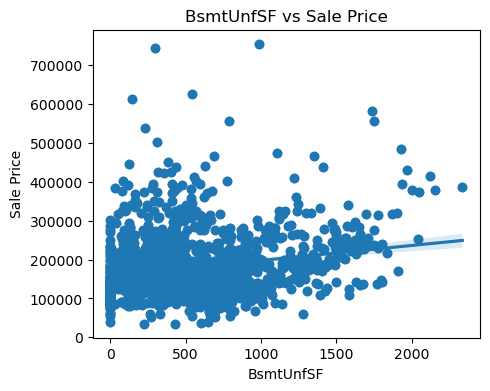

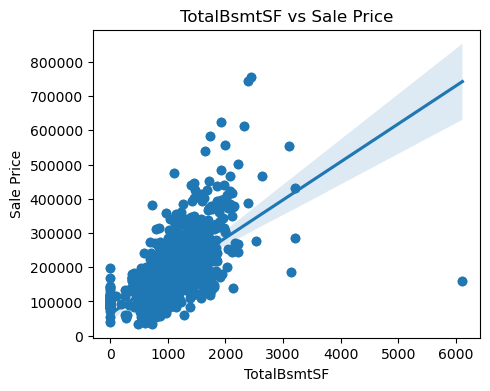

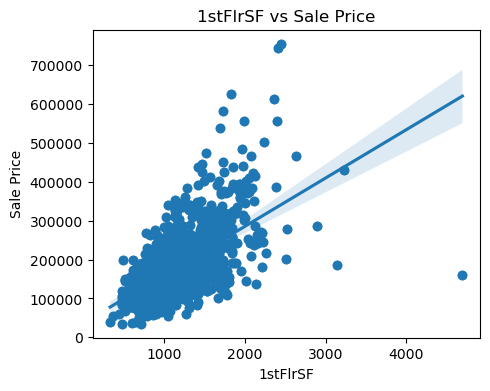

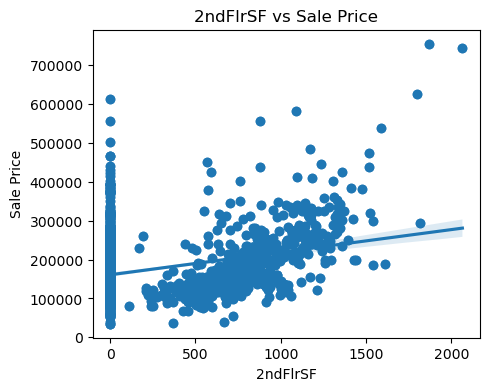

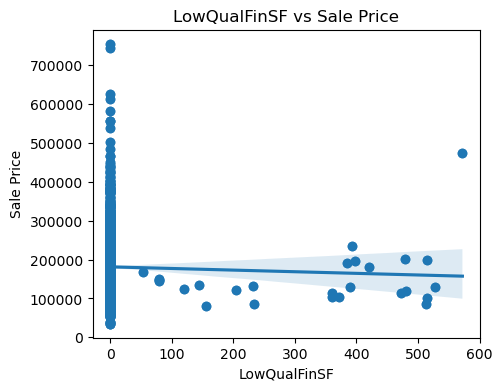

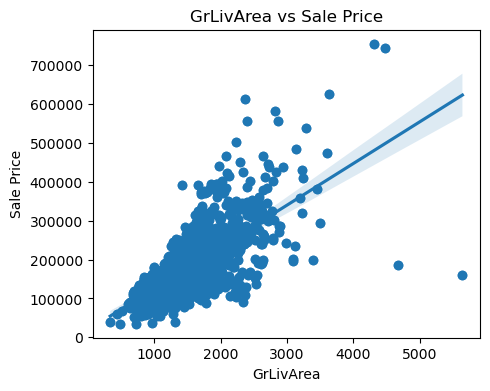

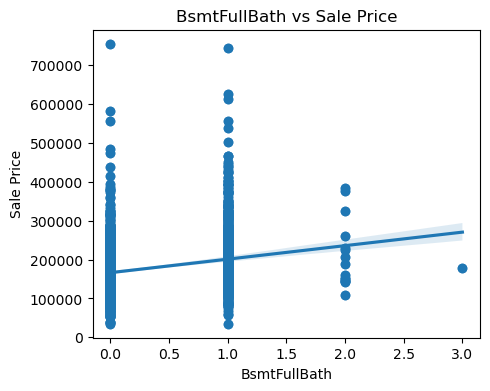

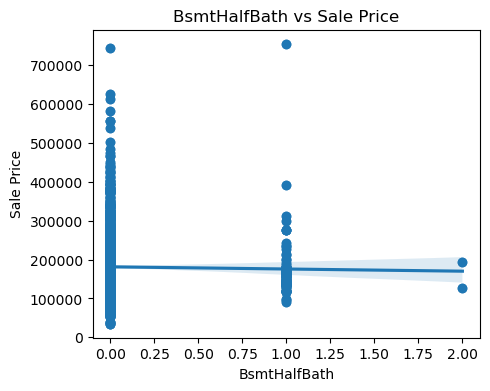

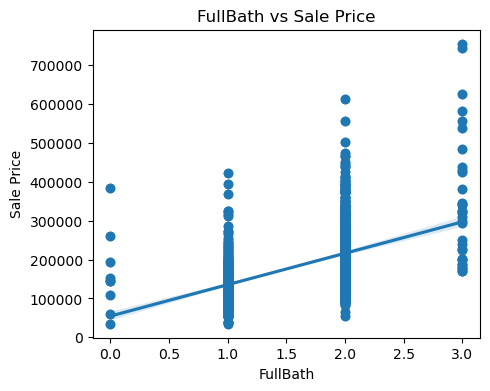

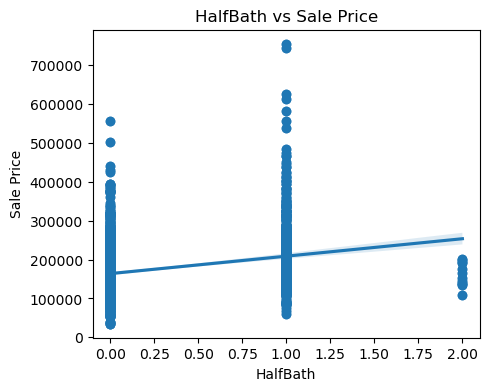

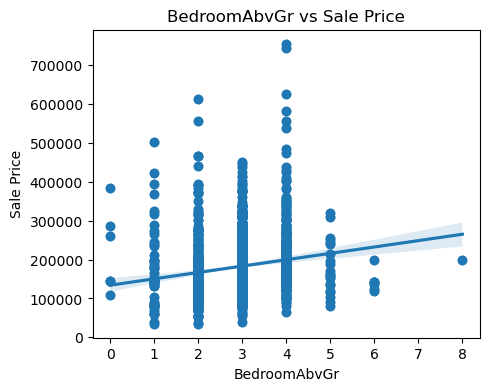

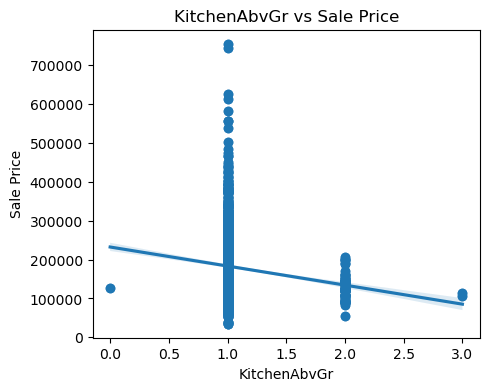

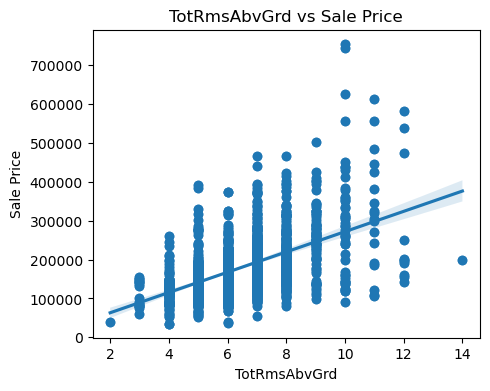

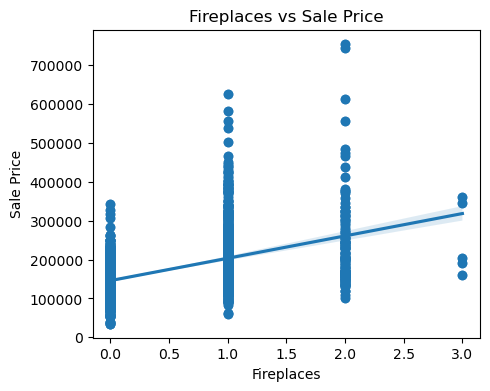

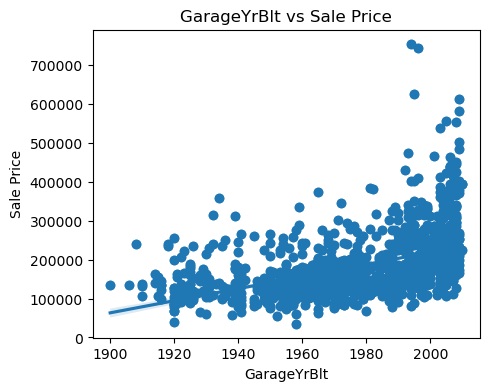

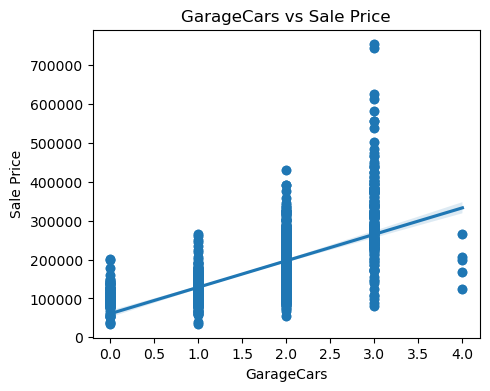

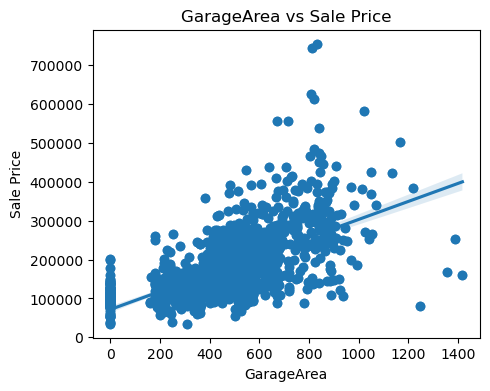

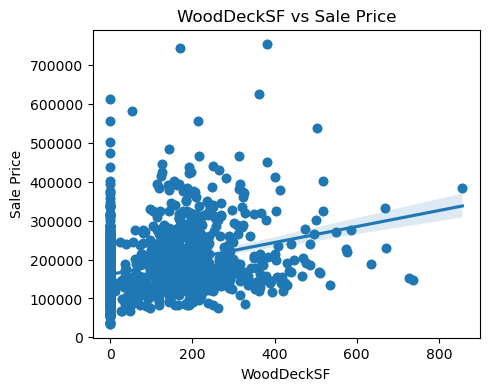

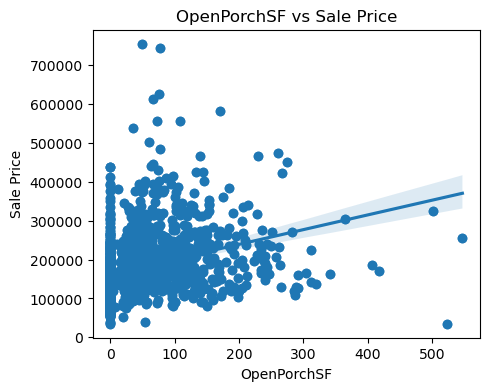

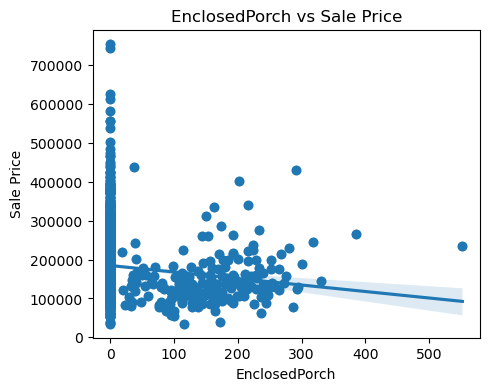

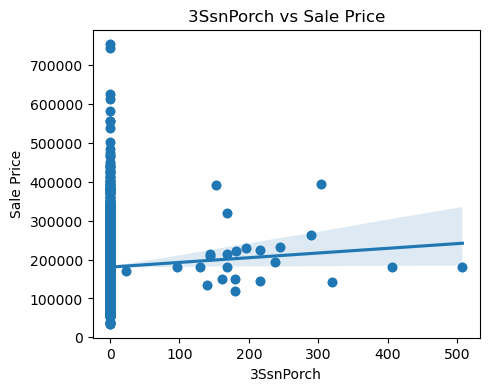

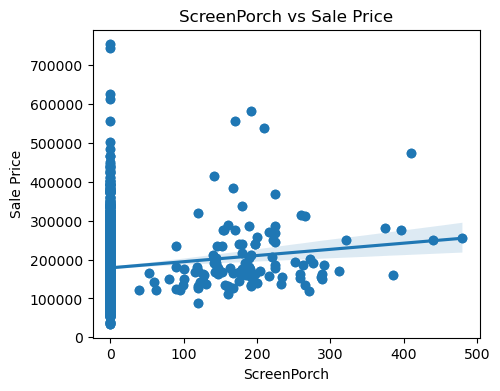

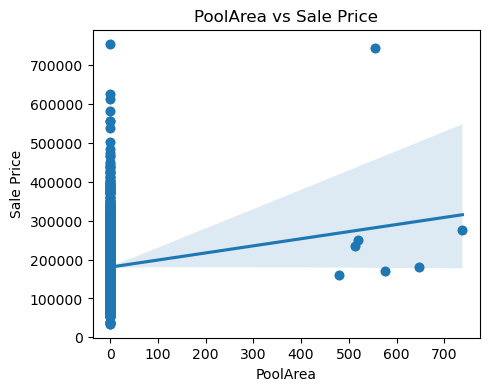

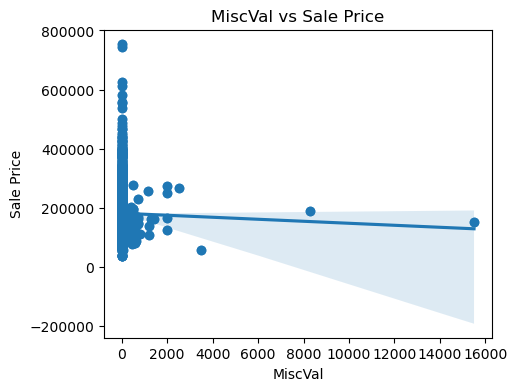

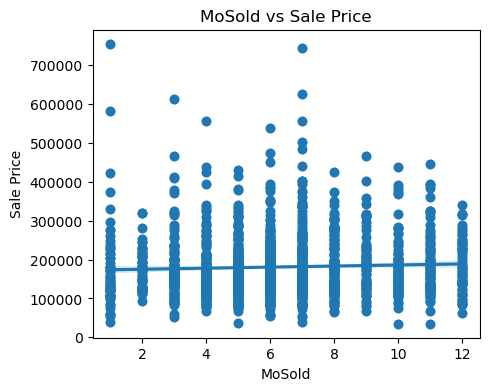

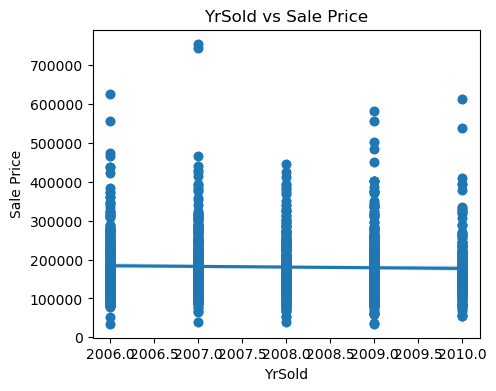

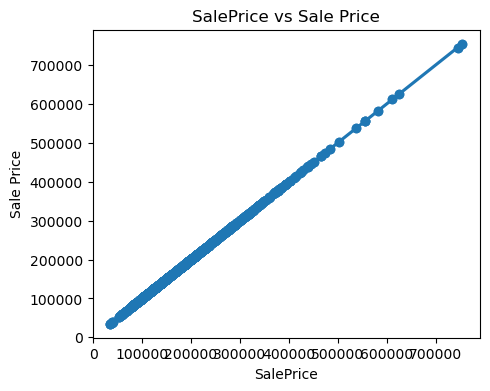

In [15]:
# Exclude ID column 
numeric_features = numeric_features.drop('Id', axis=1)

# Loop through each feature 
for col in numeric_features:
    plt.figure(figsize=(5,4))
    plt.scatter(train[col], train['SalePrice'])
    
    sns.regplot(x=col, y='SalePrice', data=train)
    
    plt.title(col + ' vs Sale Price')
    plt.xlabel(col)
    plt.ylabel('Sale Price')
    
    plt.show() 

# Explanatory data analysis

<BarContainer object of 1460 artists>

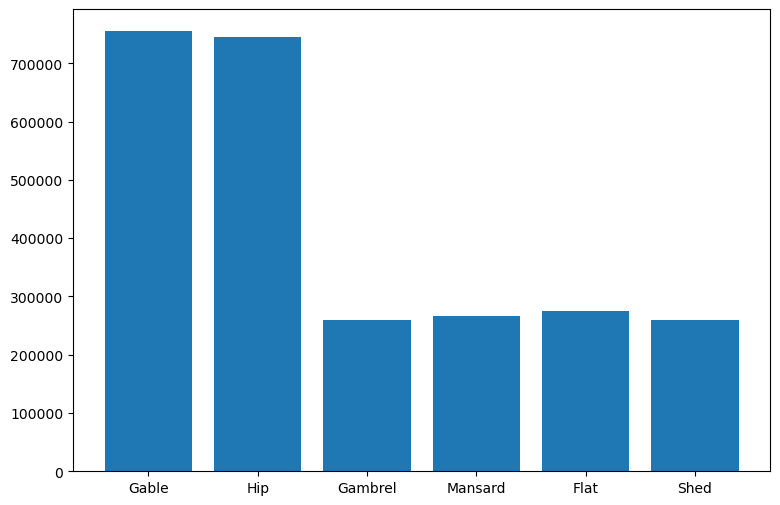

In [16]:
figure= plt.subplots(figsize=(9,6))
plt.bar(train['RoofStyle'], train['SalePrice'])

<BarContainer object of 1460 artists>

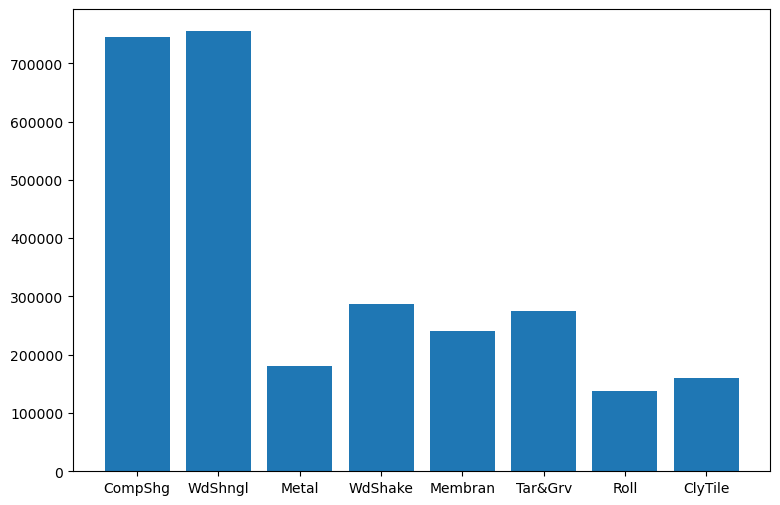

In [17]:
figure= plt.subplots(figsize=(9,6))
plt.bar(train['RoofMatl'], train['SalePrice'])


<AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice'>

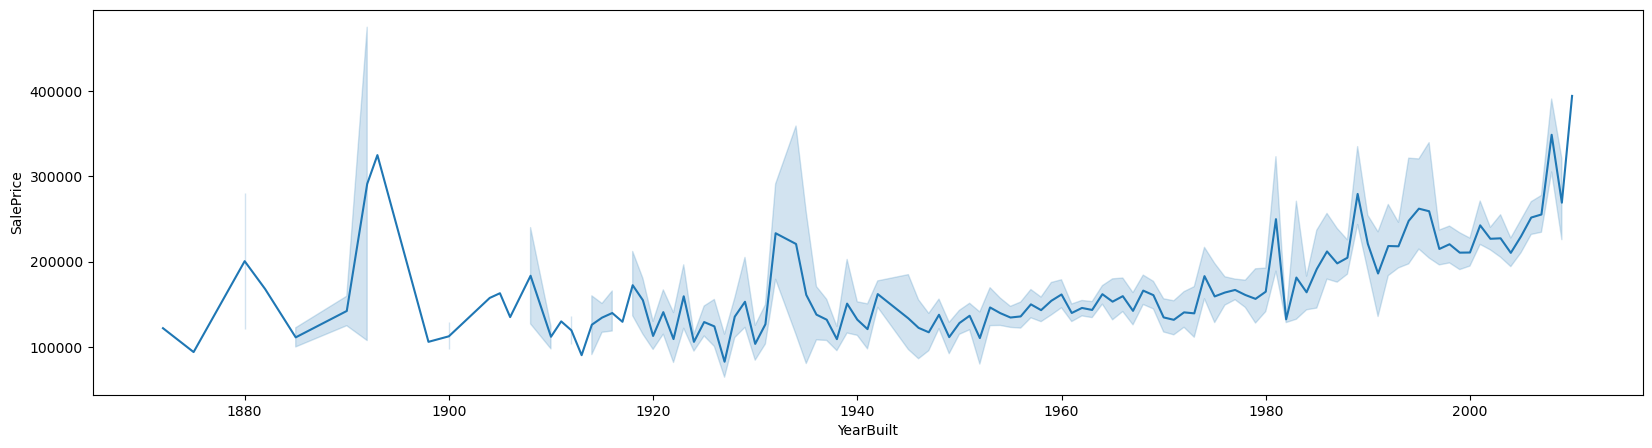

In [18]:
plt.figure(figsize=(20,5))
sns.lineplot(data=train, x="YearBuilt", y="SalePrice")

<AxesSubplot:xlabel='YearRemodAdd', ylabel='SalePrice'>

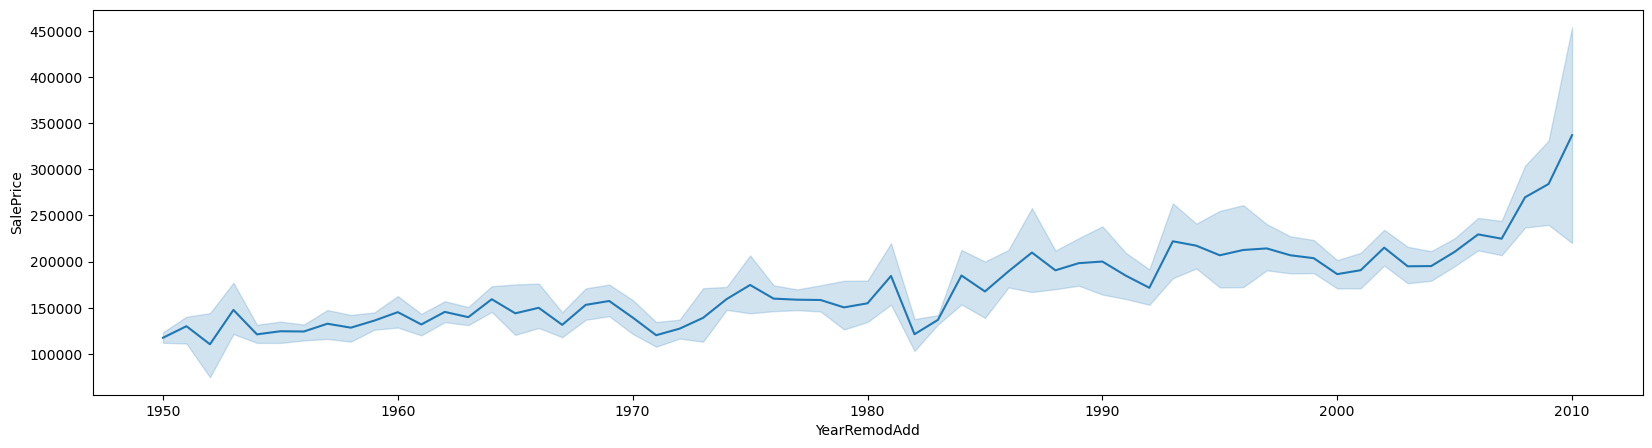

In [19]:
plt.figure(figsize=(20,5))
sns.lineplot(data=train, x="YearRemodAdd", y="SalePrice")

<BarContainer object of 1460 artists>

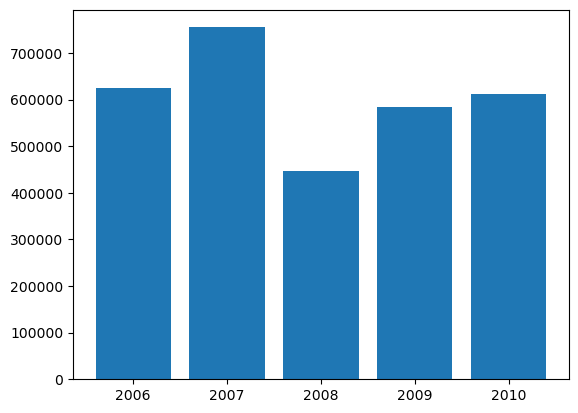

In [20]:
#sns.countplot(x='YrSold', data=train)

plt.bar(train['YrSold'], train['SalePrice'])


<BarContainer object of 1460 artists>

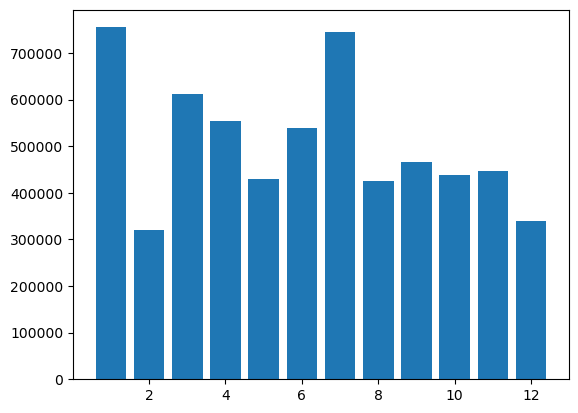

In [21]:
# sns.countplot(x='MoSold', data=train)

plt.bar(train['MoSold'], train['SalePrice'])

<BarContainer object of 1460 artists>

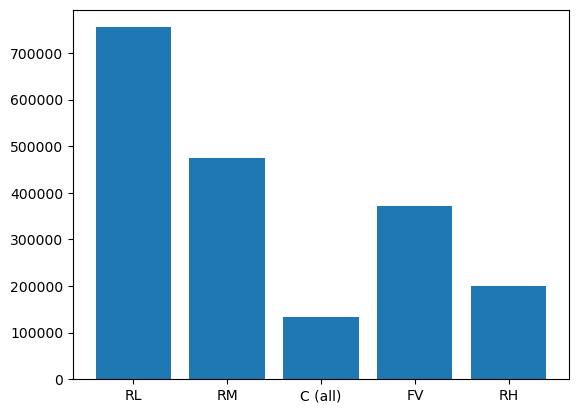

In [22]:
# sns.countplot(x='MSZoning', data=train)

plt.bar(train['MSZoning'], train['SalePrice'])

<AxesSubplot:ylabel='SaleCondition'>

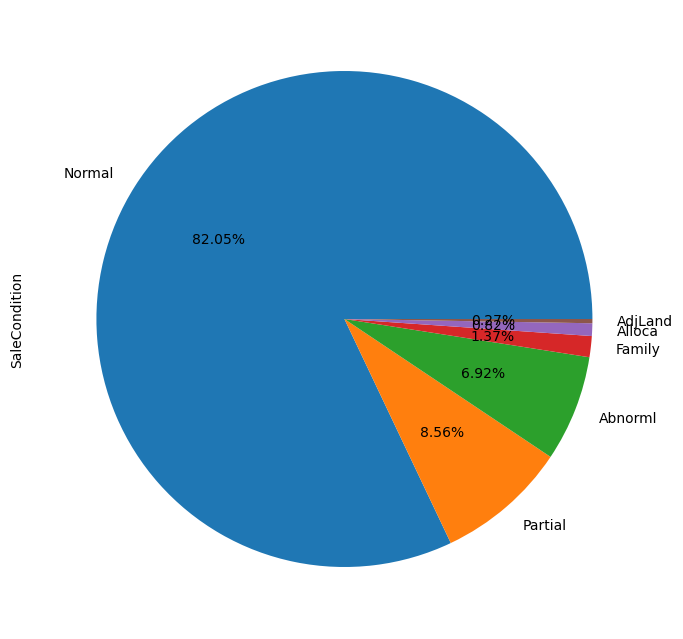

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,10))
train['SaleCondition'].value_counts(normalize=True).plot.pie(autopct='%1.2f%%')


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

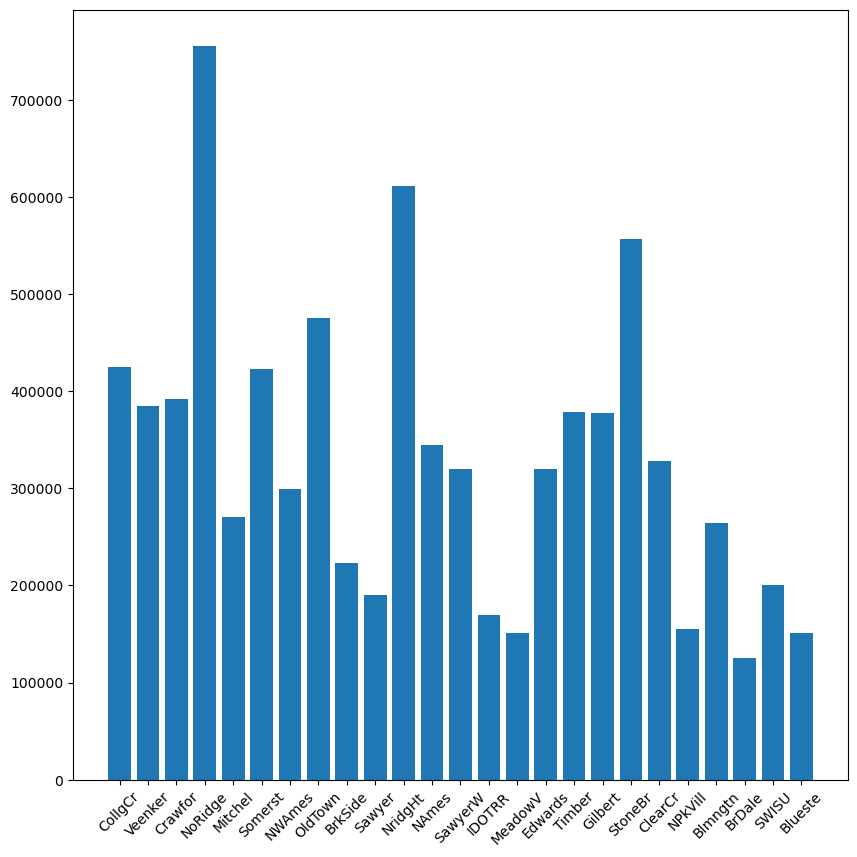

In [24]:
# sns.countplot(x='Neighborhood', data=train)

plt.figure(figsize=(10,10))
plt.bar(train['Neighborhood'], train['SalePrice'])
plt.xticks(rotation= 45)


# Missing values and Remove outliers

In [25]:
miss_col_train = train.isnull().sum()[train.isnull().sum() > 0].sort_values(ascending=True)
percent_miss_train = round((miss_col_train / len(train) * 100) , 2)
missing_train = pd.DataFrame([miss_col_train, percent_miss_train]).T.rename(columns={0:'Feature', 1:'missing'})
missing_train

Feature  missing
Electrical        1.0     0.07
MasVnrType        8.0     0.55
MasVnrArea        8.0     0.55
BsmtQual         37.0     2.53
BsmtCond         37.0     2.53
BsmtFinType1     37.0     2.53
BsmtExposure     38.0     2.60
BsmtFinType2     38.0     2.60
GarageCond       81.0     5.55
GarageQual       81.0     5.55
GarageFinish     81.0     5.55
GarageType       81.0     5.55
GarageYrBlt      81.0     5.55
LotFrontage     259.0    17.74
FireplaceQu     690.0    47.26
Fence          1179.0    80.75
Alley          1369.0    93.77
MiscFeature    1406.0    96.30
PoolQC         1453.0    99.52

In [26]:
train.fillna(value=0, inplace=True)

# Replace infinite values with a large finite value or np.nan, and then handle the np.nan values as before
train.replace([np.inf, -np.inf], np.nan, inplace=True)
train.fillna(value=0, inplace=True)


In [27]:
train.isnull().sum()


Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 81, dtype: int64

## Remove outliers

In [28]:
cat_features = np.array([i for i in train.columns.tolist() if train[i].dtype == 'object'])
num_features = np.array([i for i in train.columns.tolist() if train[i].dtype != 'object'])


In [29]:
print("Number features column =" , len(num_features))
print("Categorial features column =" , len(cat_features))

Number features column = 38
Categorial features column = 43


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


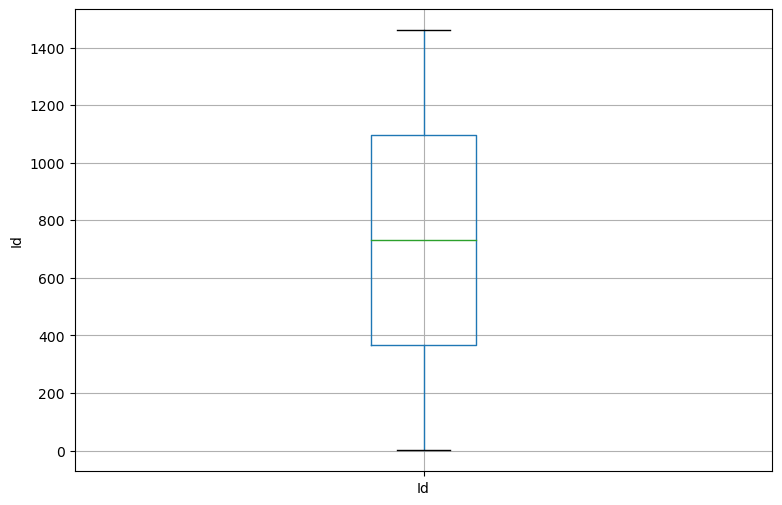

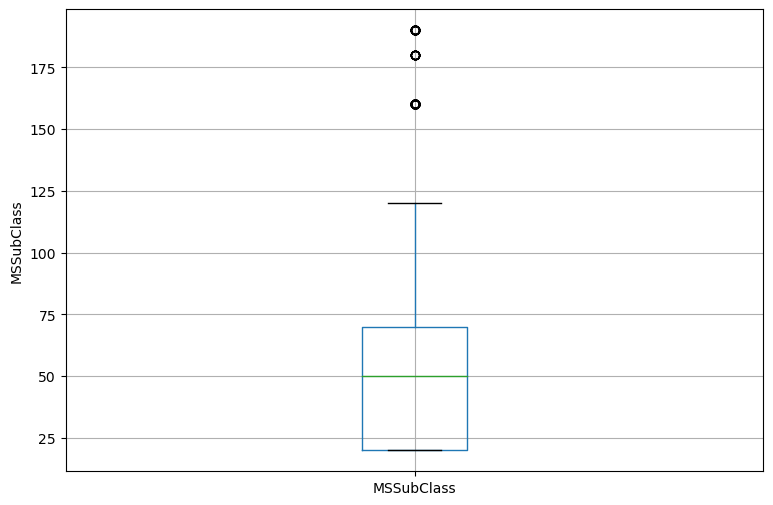

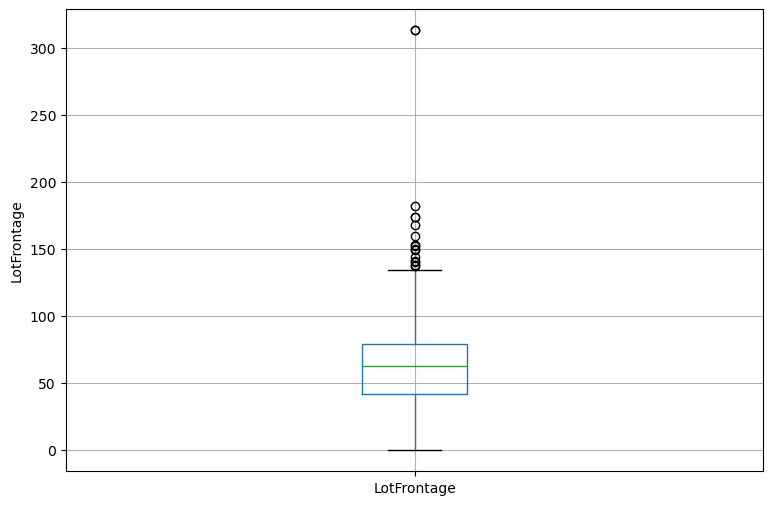

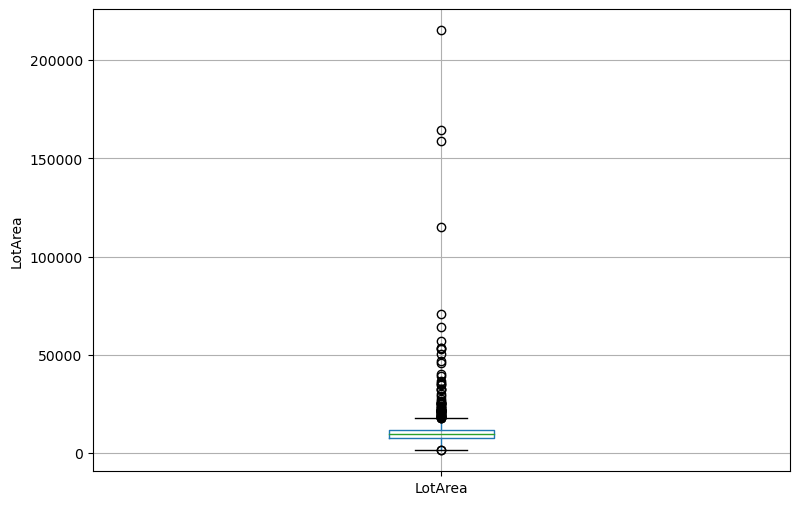

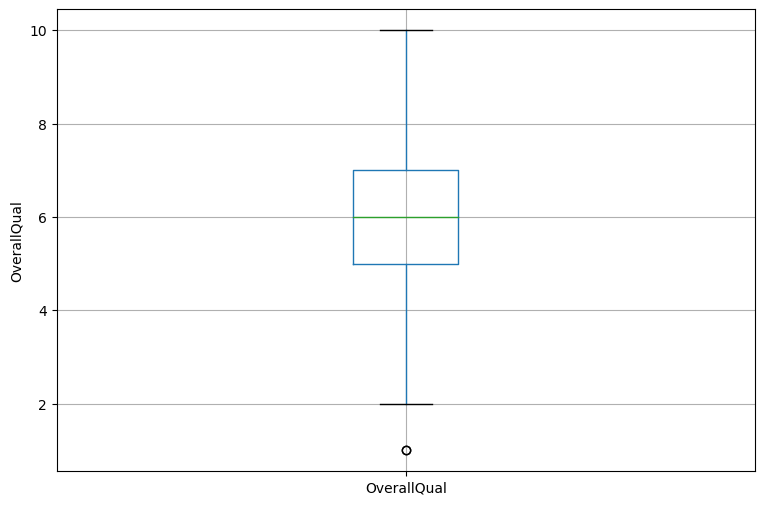

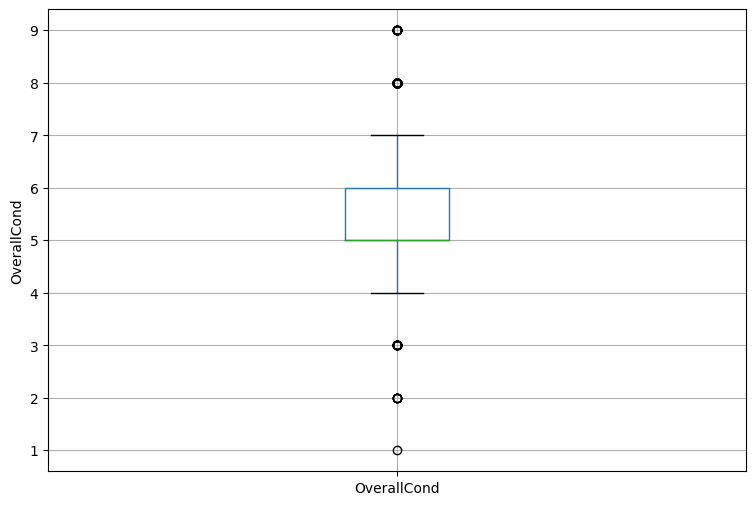

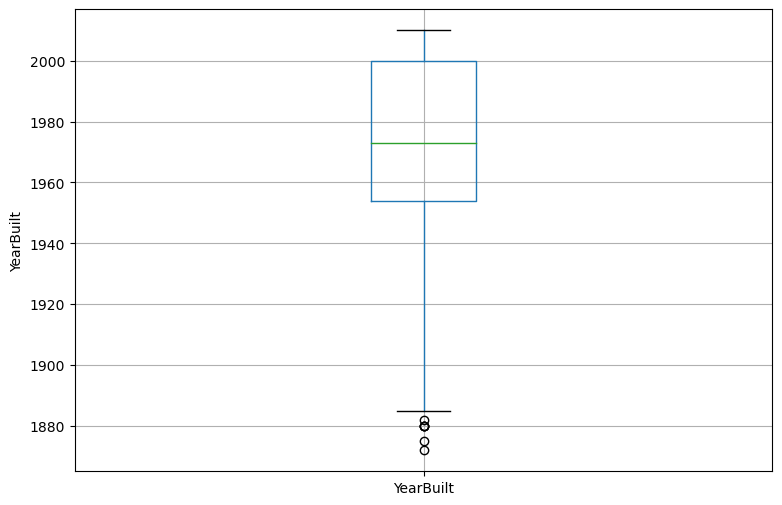

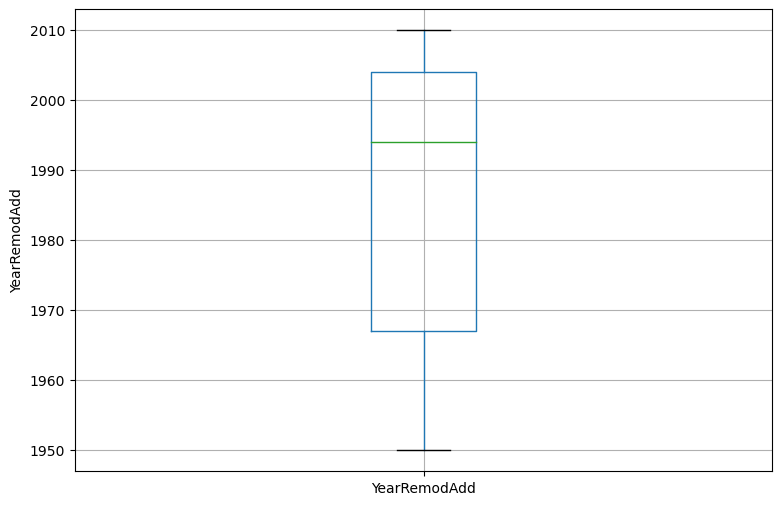

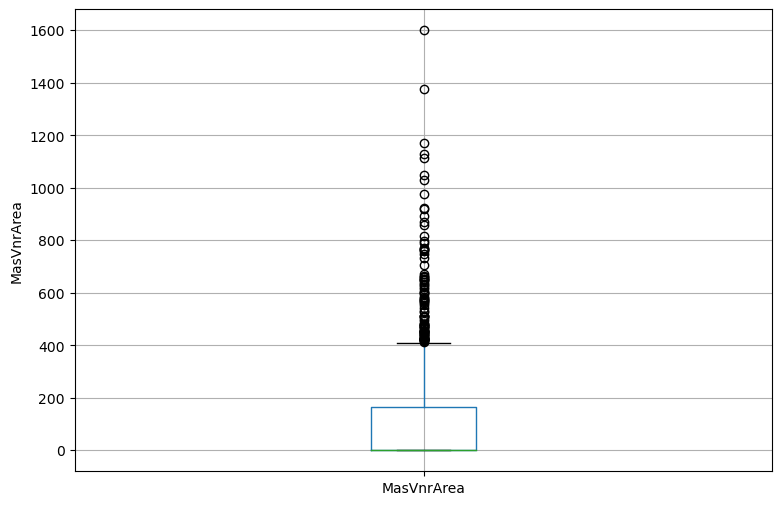

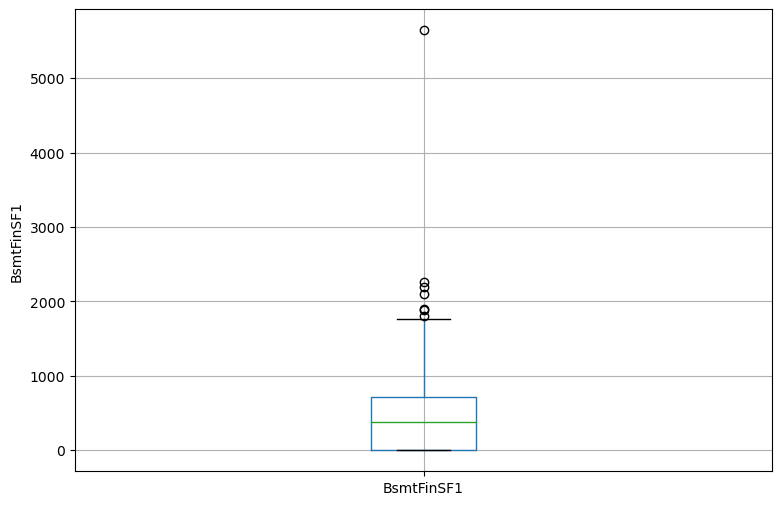

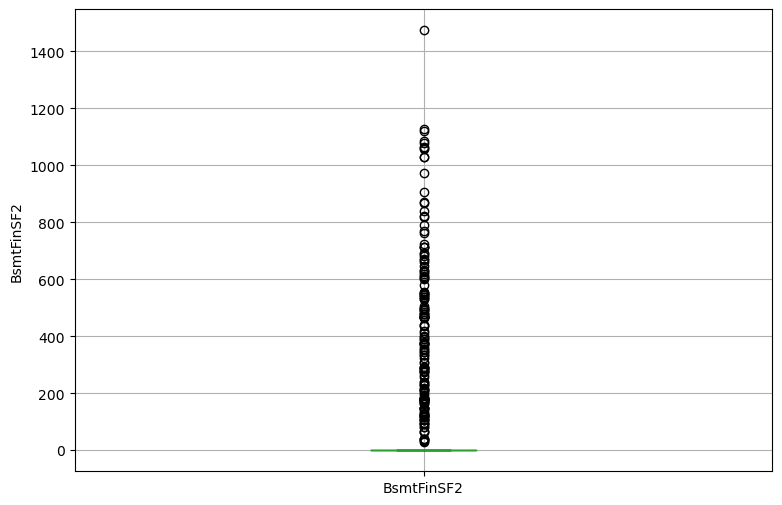

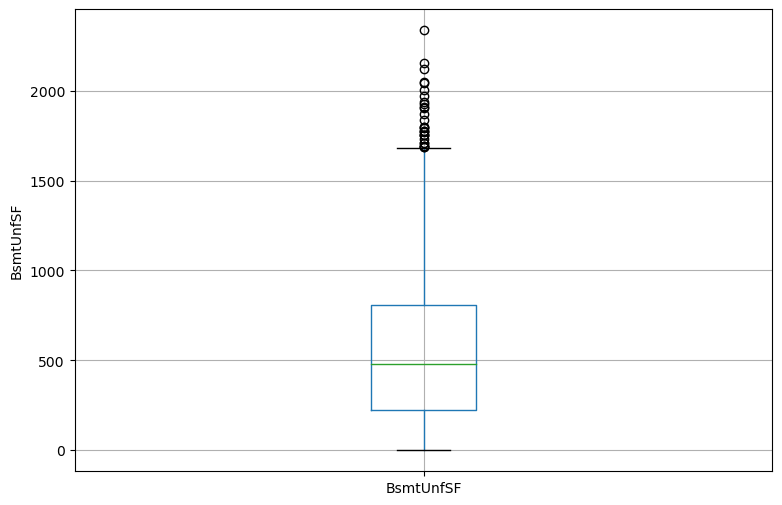

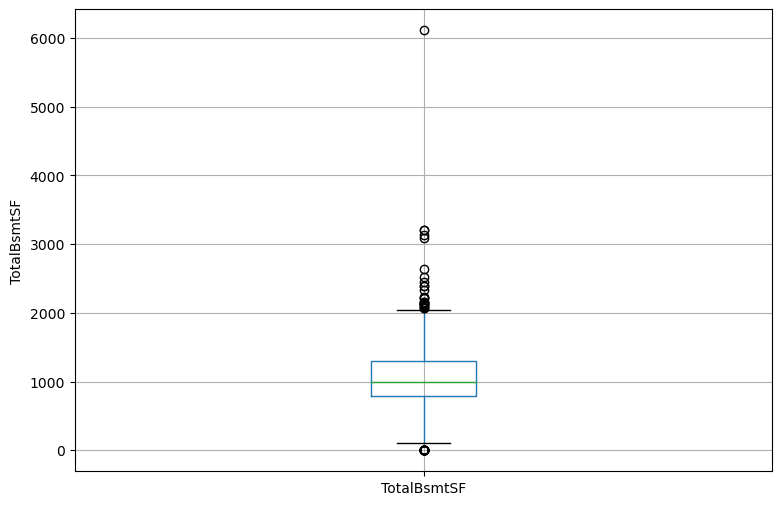

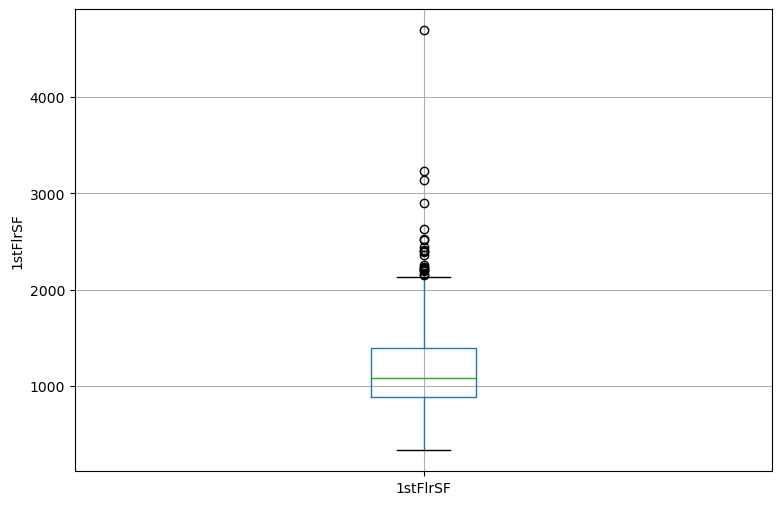

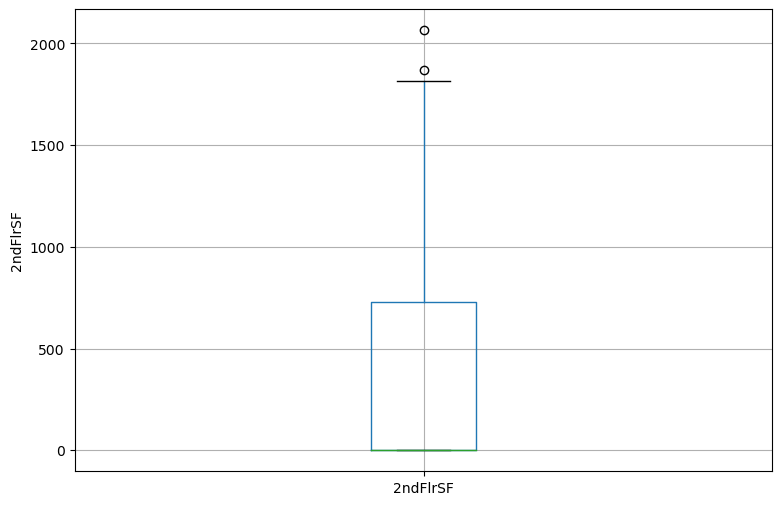

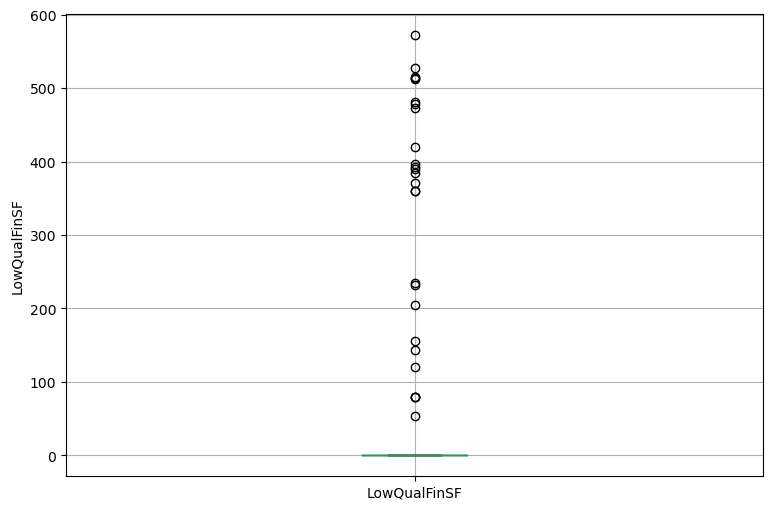

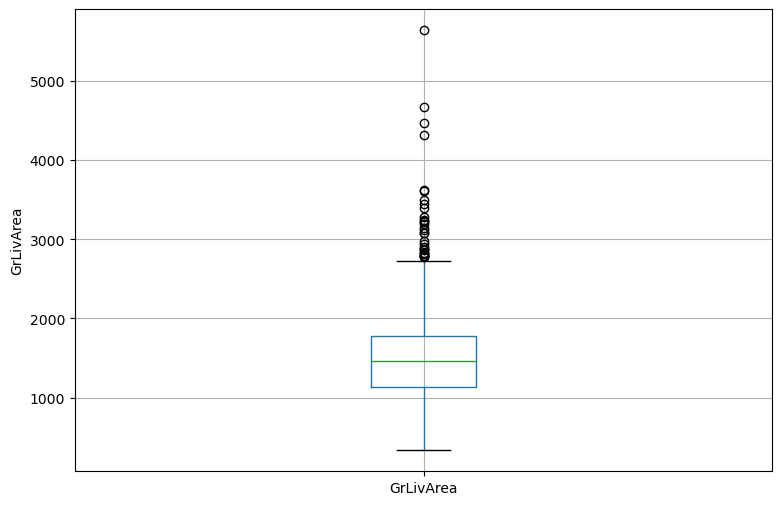

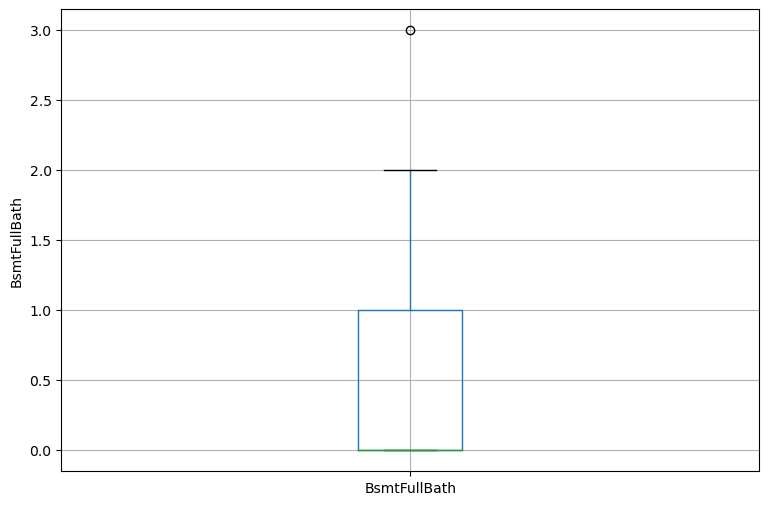

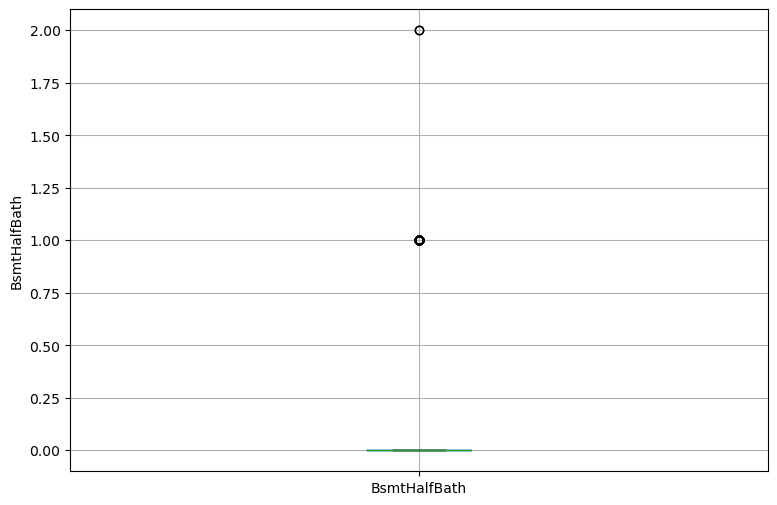

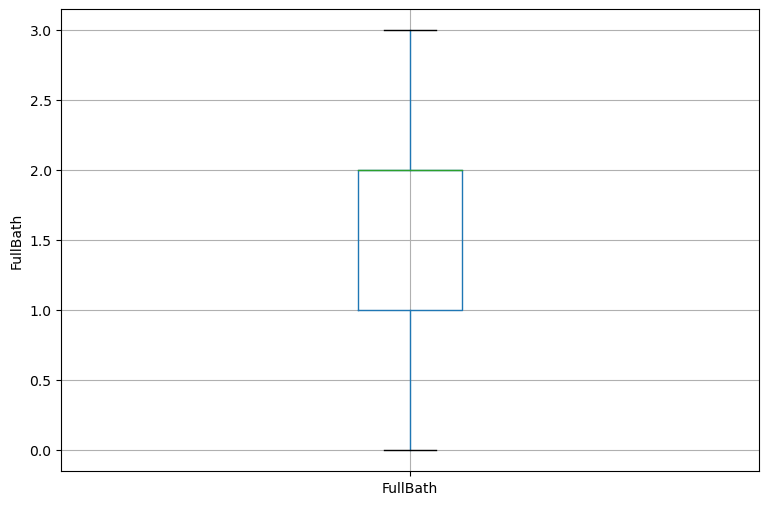

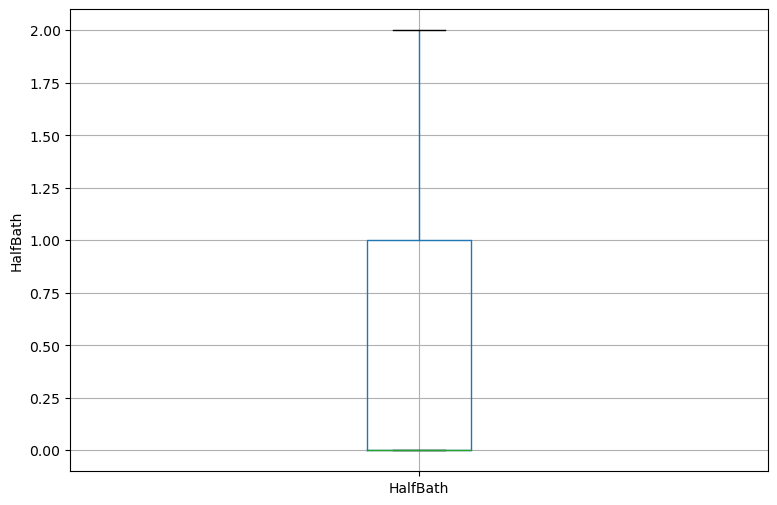

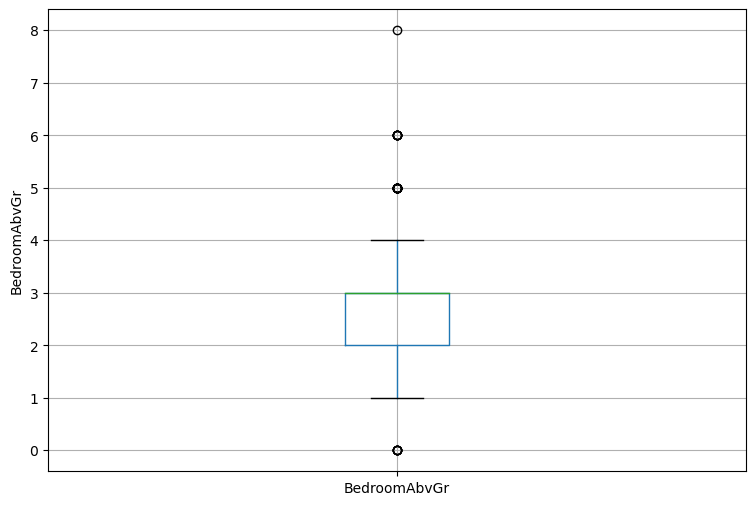

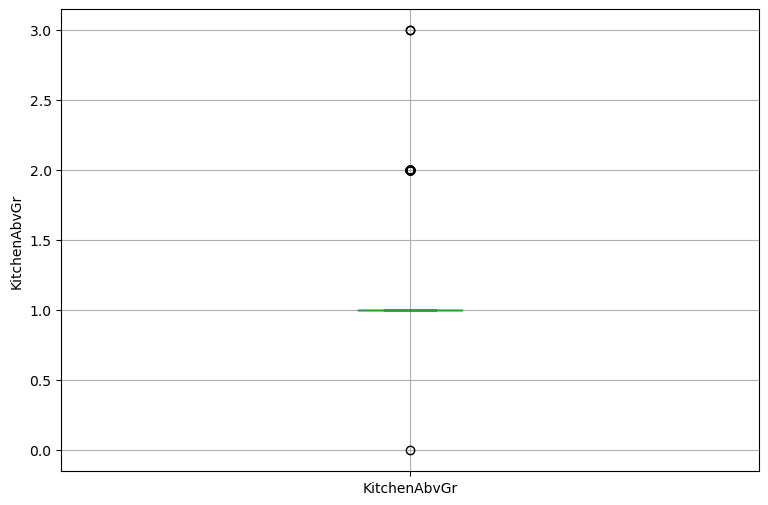

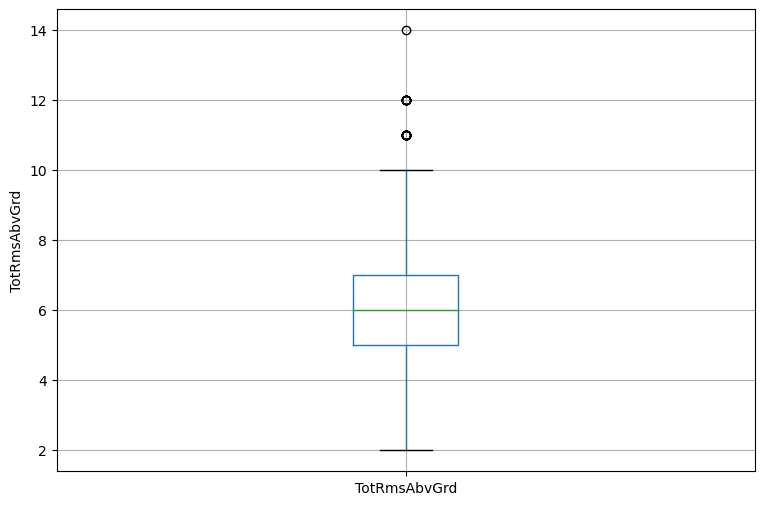

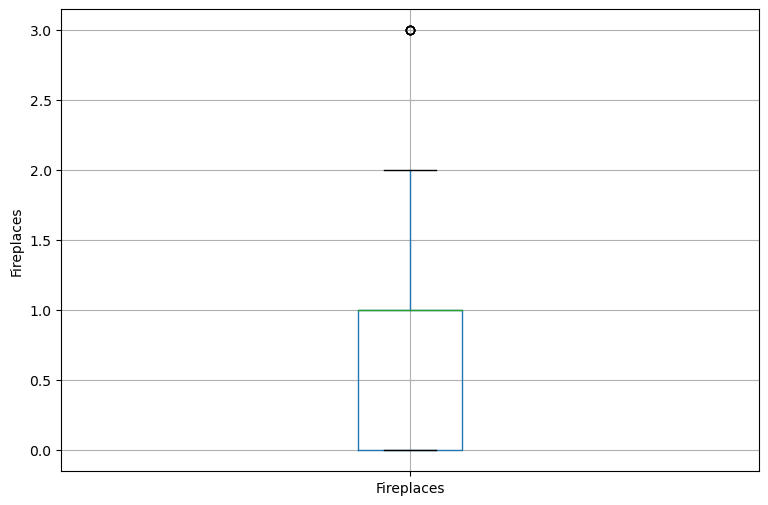

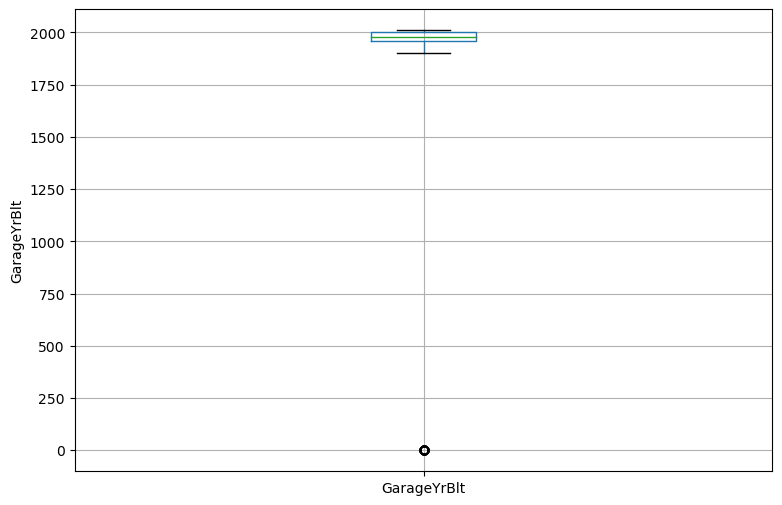

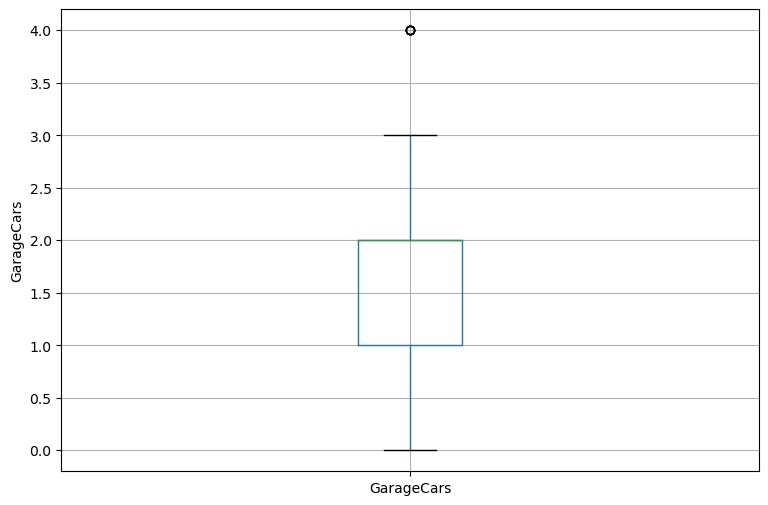

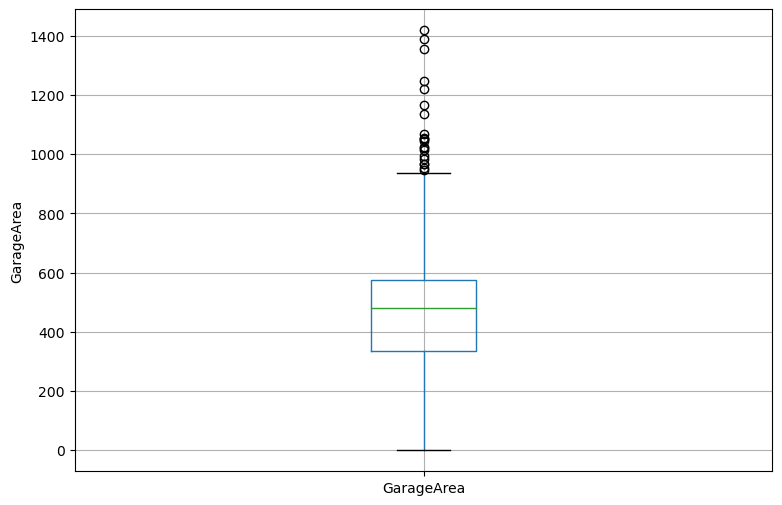

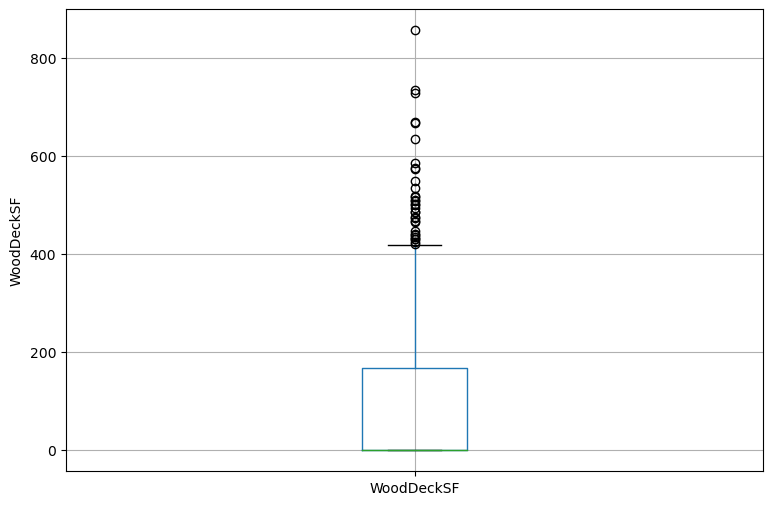

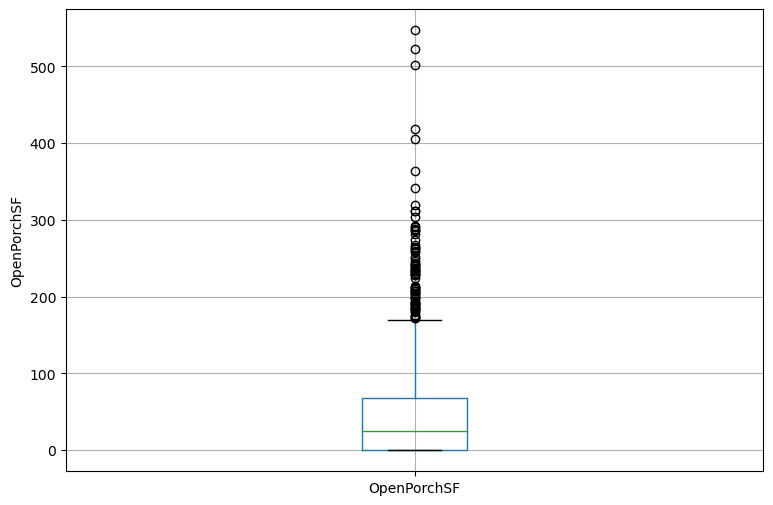

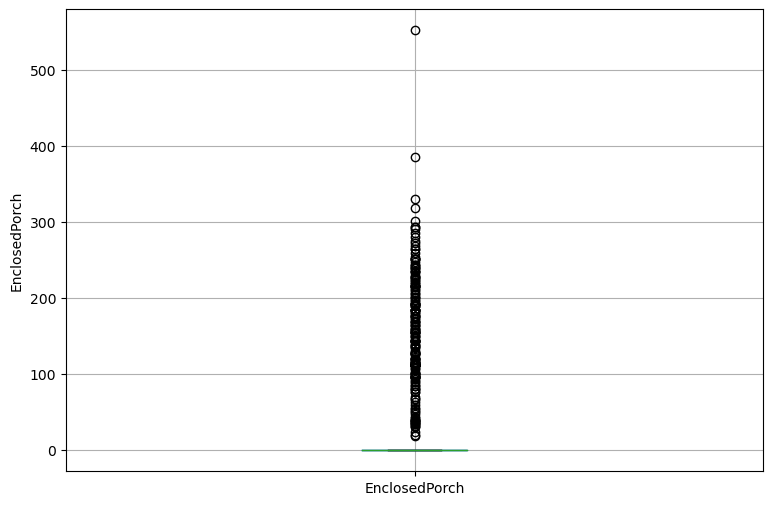

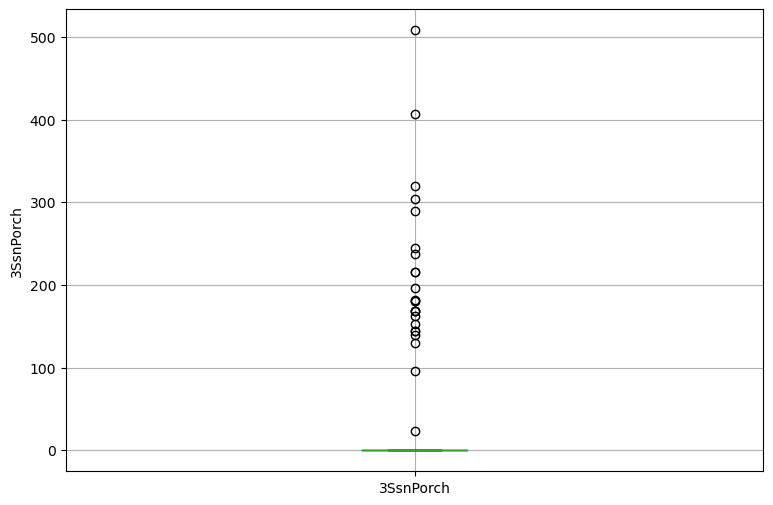

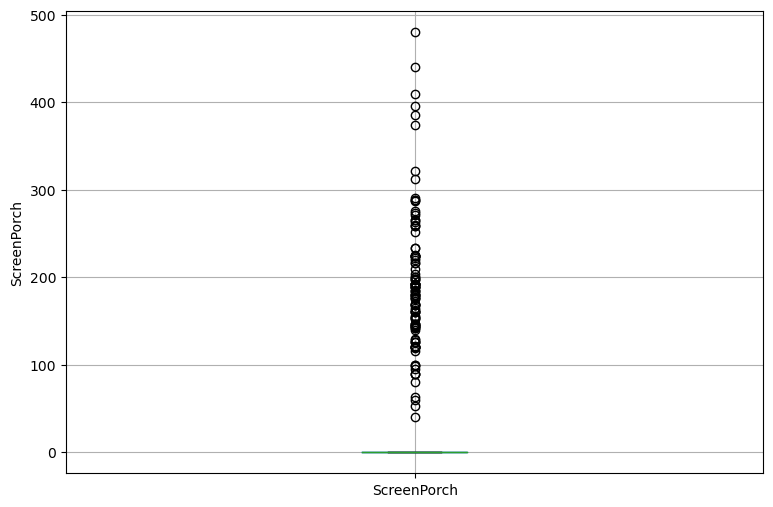

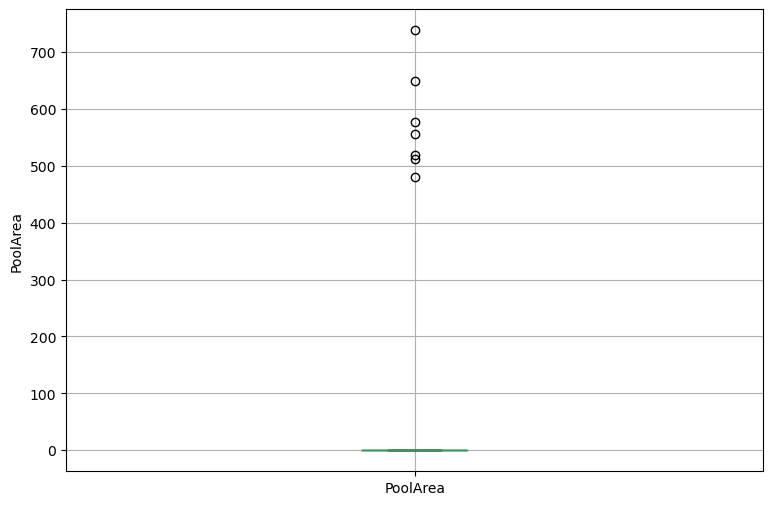

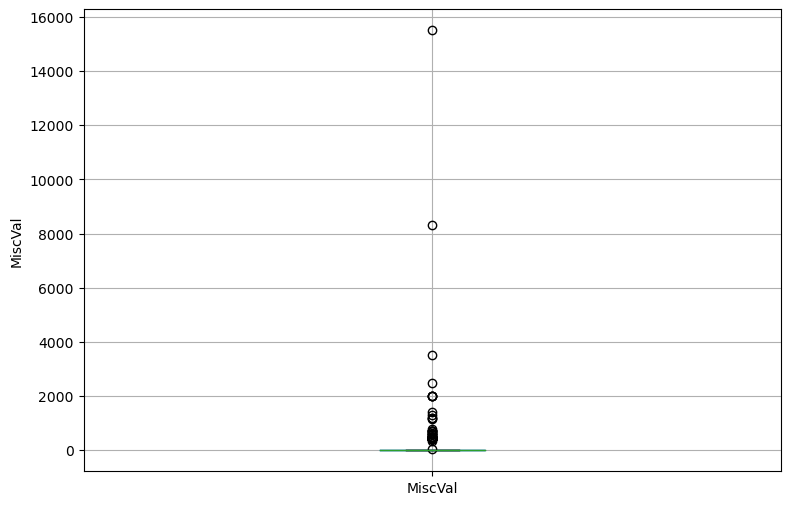

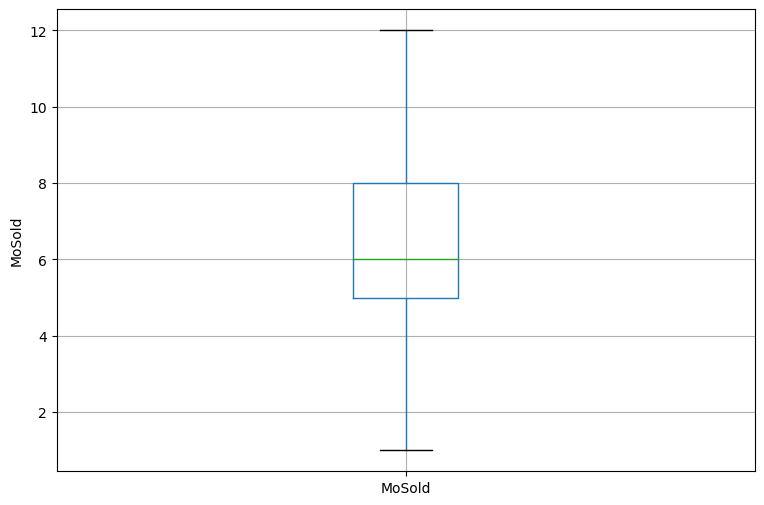

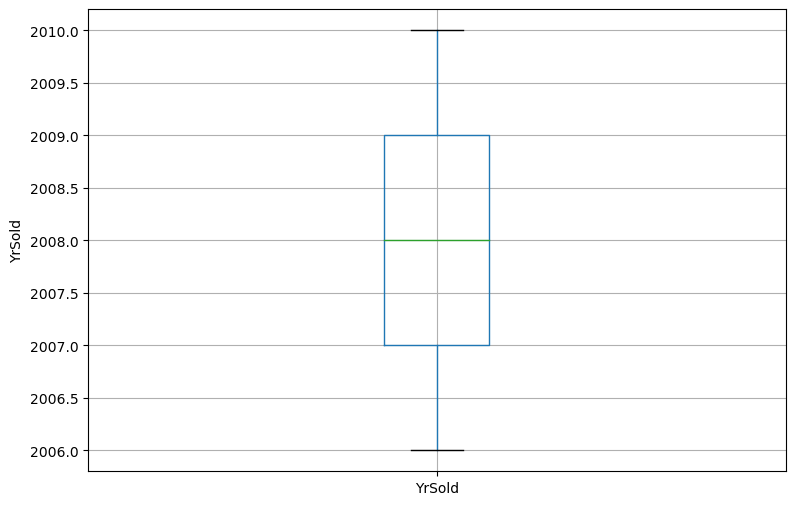

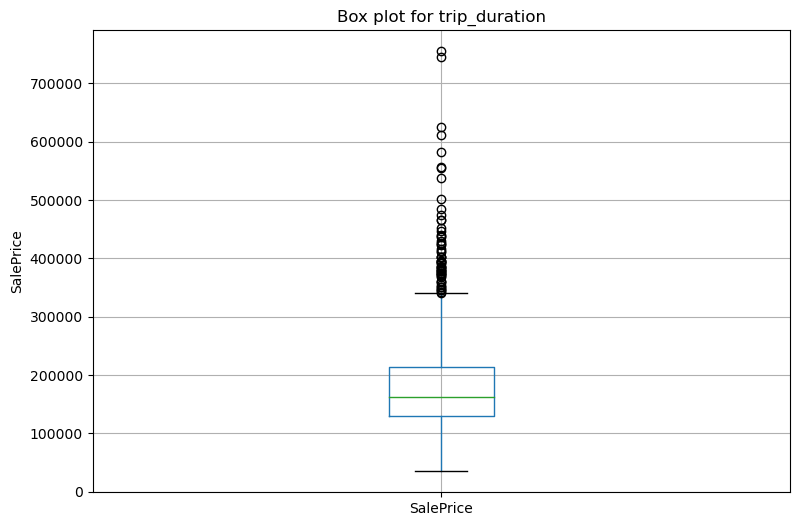

In [30]:
# plot a boxplot for the label by each numerical feature  
for col in train.describe().columns:
  fig = plt.figure(figsize=(9, 6))
  ax = fig.gca()
  train.boxplot(column = col, ax = ax)
  ax.set_ylabel(col)
plt.title("Box plot for trip_duration")
plt.show()

In [31]:
# Function to detect outliers
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.25)
    quartile3 = dataframe[variable].quantile(0.75)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


## function to remove outliers
def replace_with_thresholds(dataframe,columns):
    for col in columns:
        low_limit, up_limit = outlier_thresholds(dataframe, col)
        dataframe.loc[(dataframe[col] < low_limit), col] = low_limit
        dataframe.loc[(dataframe[col] > up_limit), col] = up_limit

In [32]:
replace_with_thresholds(train, num_features)

# Corralation

<AxesSubplot:>

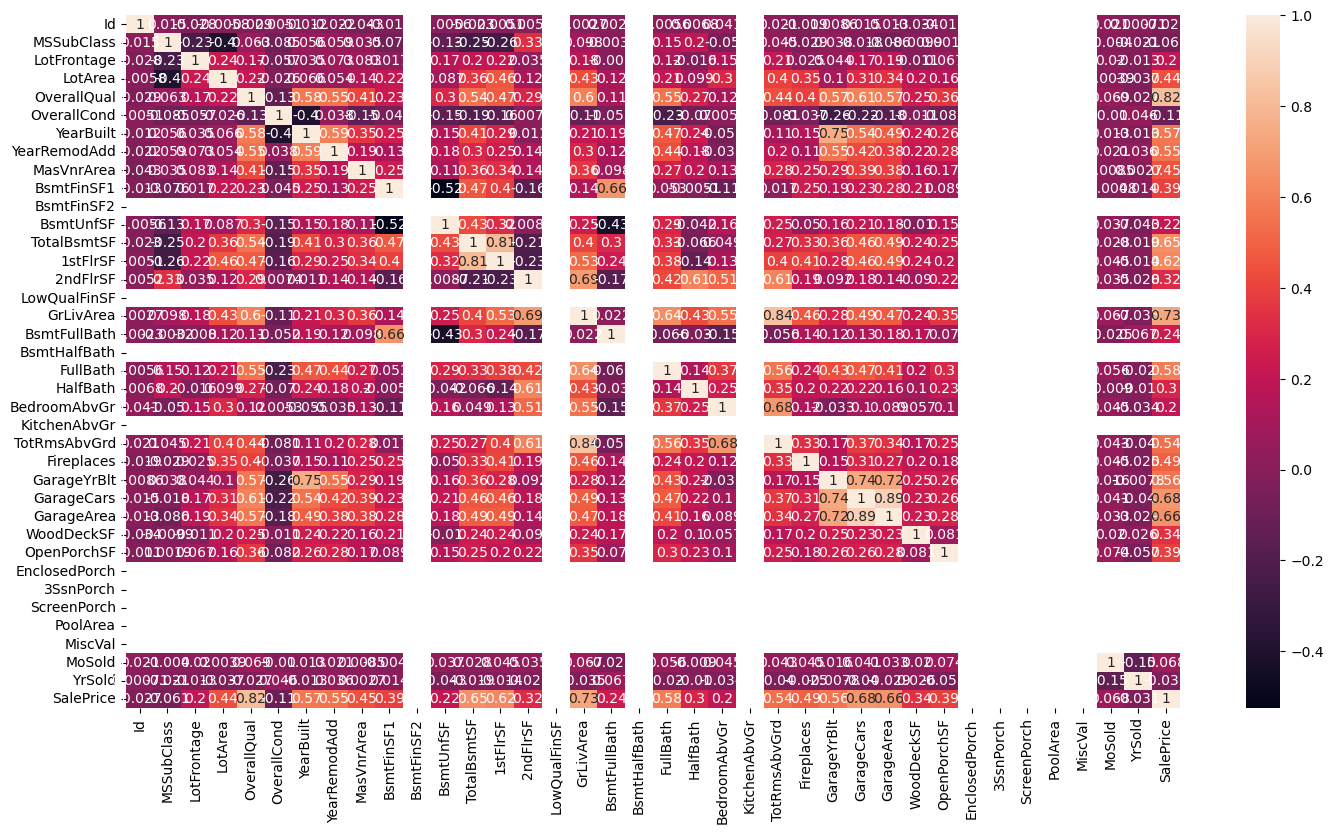

In [33]:
train_corr = train.select_dtypes(include=[np.number])

corr = train_corr.corr()
plt.subplots(figsize=(17,9))
sns.heatmap(corr, annot=True)

In [34]:
print("Find most important features relative to target")
corr = train.corr()
corr.sort_values(['SalePrice'], ascending=False, inplace=True)
corr.SalePrice

Find most important features relative to target


SalePrice        1.000000
OverallQual      0.817680
GrLivArea        0.729311
GarageCars       0.675896
GarageArea       0.660029
TotalBsmtSF      0.645251
1stFlrSF         0.621873
FullBath         0.583994
YearBuilt        0.570327
GarageYrBlt      0.558816
YearRemodAdd     0.552061
TotRmsAbvGrd     0.539339
Fireplaces       0.488253
MasVnrArea       0.450751
LotArea          0.435876
OpenPorchSF      0.394637
BsmtFinSF1       0.387586
WoodDeckSF       0.343660
2ndFlrSF         0.316508
HalfBath         0.295110
BsmtFullBath     0.240345
BsmtUnfSF        0.216006
BedroomAbvGr     0.199360
LotFrontage      0.196023
MoSold           0.068075
Id              -0.027439
YrSold          -0.031358
MSSubClass      -0.061456
OverallCond     -0.105920
BsmtFinSF2            NaN
LowQualFinSF          NaN
BsmtHalfBath          NaN
KitchenAbvGr          NaN
EnclosedPorch         NaN
3SsnPorch             NaN
ScreenPorch           NaN
PoolArea              NaN
MiscVal               NaN
Name: SalePr

## Top 50% Corralation train attributes with sale-price

In [35]:
# Top 50% Corralation train attributes with sale-price

# important_num_cols = list(train.corr()["SalePrice"][(train.corr()["SalePrice"]>0.5)|(train.corr()["SalePrice"]<-0.5)].index)
# important_num_cols

In [36]:
train.describe(include=['int64'])

MSSubClass  OverallQual    YearBuilt  BsmtFinSF2  TotalBsmtSF  \
count  1460.000000  1460.000000  1460.000000      1460.0  1460.000000   
mean     55.085616     6.100685  1971.299315         0.0  1050.254795   
std      37.508183     1.378430    30.108397         0.0   397.937878   
min      20.000000     2.000000  1885.000000         0.0    42.000000   
25%      20.000000     5.000000  1954.000000         0.0   795.750000   
50%      50.000000     6.000000  1973.000000         0.0   991.500000   
75%      70.000000     7.000000  2000.000000         0.0  1298.250000   
max     145.000000    10.000000  2010.000000         0.0  2052.000000   

          2ndFlrSF  LowQualFinSF  BsmtHalfBath  KitchenAbvGr  TotRmsAbvGrd  \
count  1460.000000        1460.0        1460.0        1460.0   1460.000000   
mean    346.789041           0.0           0.0           1.0      6.487671   
std     435.791621           0.0           0.0           0.0      1.541916   
min       0.000000           0.0           0.0           1.0      2.000000   
25%       0.000000           0.0           0.0           1.0      5.000000   
50%       0.000000           0.0           0.0           1.0      6.000000   
75%     728.000000           0.0           0.0           1.0      7.000000   
max    1820.000000           0.0           0.0           1.0     10.000000   

        WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
count  1460.000000  1460.000000         1460.0     1460.0       1460.0   
mean     91.806849    42.603425            0.0        0.0          0.0   
std     116.658120    52.501584            0.0        0.0          0.0   
min       0.000000     0.000000            0.0        0.0          0.0   
25%       0.000000     0.000000            0.0        0.0          0.0   
50%       0.000000    25.000000            0.0        0.0          0.0   
75%     168.000000    68.000000            0.0        0.0          0.0   
max     420.000000   170.000000            0.0        0.0          0.0   

       PoolArea  MiscVal       YrSold  
count    1460.0   1460.0  1460.000000  
mean        0.0      0.0  2007.815753  
std         0.0      0.0     1.328095  
min         0.0      0.0  2006.000000  
25%         0.0      0.0  2007.000000  
50%         0.0      0.0  2008.000000  
75%         0.0      0.0  2009.000000  
max         0.0      0.0  2010.000000

In [37]:
top_feature = corr.index[abs(corr['SalePrice']>0.5)]
top_feature

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearBuilt', 'GarageYrBlt',
       'YearRemodAdd', 'TotRmsAbvGrd'],
      dtype='object')

In [38]:
col = ['SalePrice','OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt',
       'YearRemodAdd']

In [39]:
numcols = train[train.columns.intersection(top_feature)]
numcols.head()

OverallQual  YearBuilt  YearRemodAdd  TotalBsmtSF  1stFlrSF  GrLivArea  \
0            7       2003        2003.0          856     856.0     1710.0   
1            6       1976        1976.0         1262    1262.0     1262.0   
2            7       2001        2002.0          920     920.0     1786.0   
3            7       1915        1970.0          756     961.0     1717.0   
4            8       2000        2000.0         1145    1145.0     2198.0   

   FullBath  TotRmsAbvGrd  GarageYrBlt  GarageCars  GarageArea  SalePrice  
0       2.0             8       2003.0         2.0       548.0   208500.0  
1       2.0             6       1976.0         2.0       460.0   181500.0  
2       2.0             6       2001.0         2.0       608.0   223500.0  
3       1.0             7       1998.0         3.0       642.0   140000.0  
4       2.0             9       2000.0         3.0       836.0   250000.0

<AxesSubplot:>

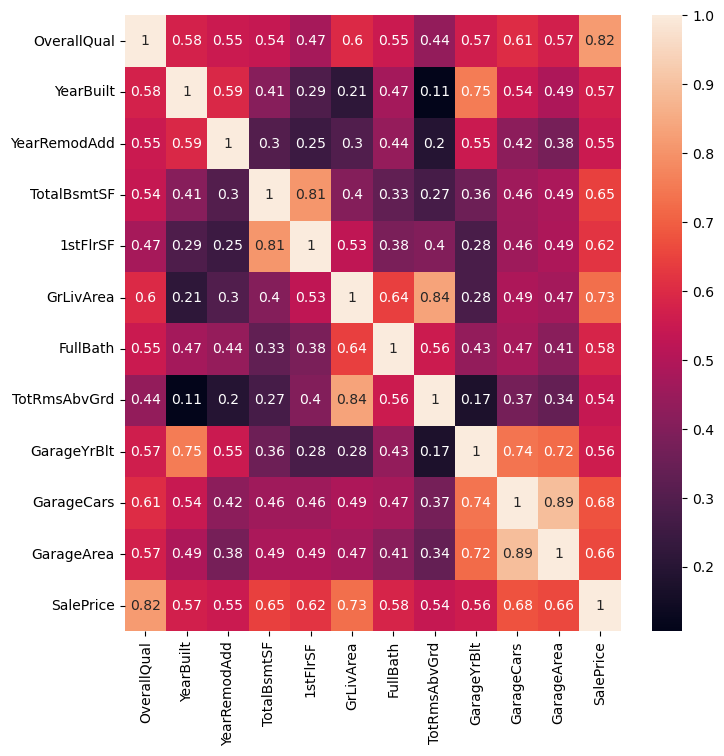

In [40]:
numcols = train[train.columns.intersection(top_feature)]
plt.figure(figsize=(8,8))
sns.heatmap(numcols.corr(), annot=True)

In [41]:
# top_feature = corr.index[abs(corr['SalePrice']>0.5)]
# plt.subplots(figsize=(9, 8))
# top_corr = train[top_feature].corr()
# sns.heatmap(top_corr, annot=True)
# plt.show()

In [42]:
# plt.figure(figsize=(8, 6))
# sns.boxplot(x=train.OverallQual, y=train.SalePrice)

# train.OverallQual.nunique()

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


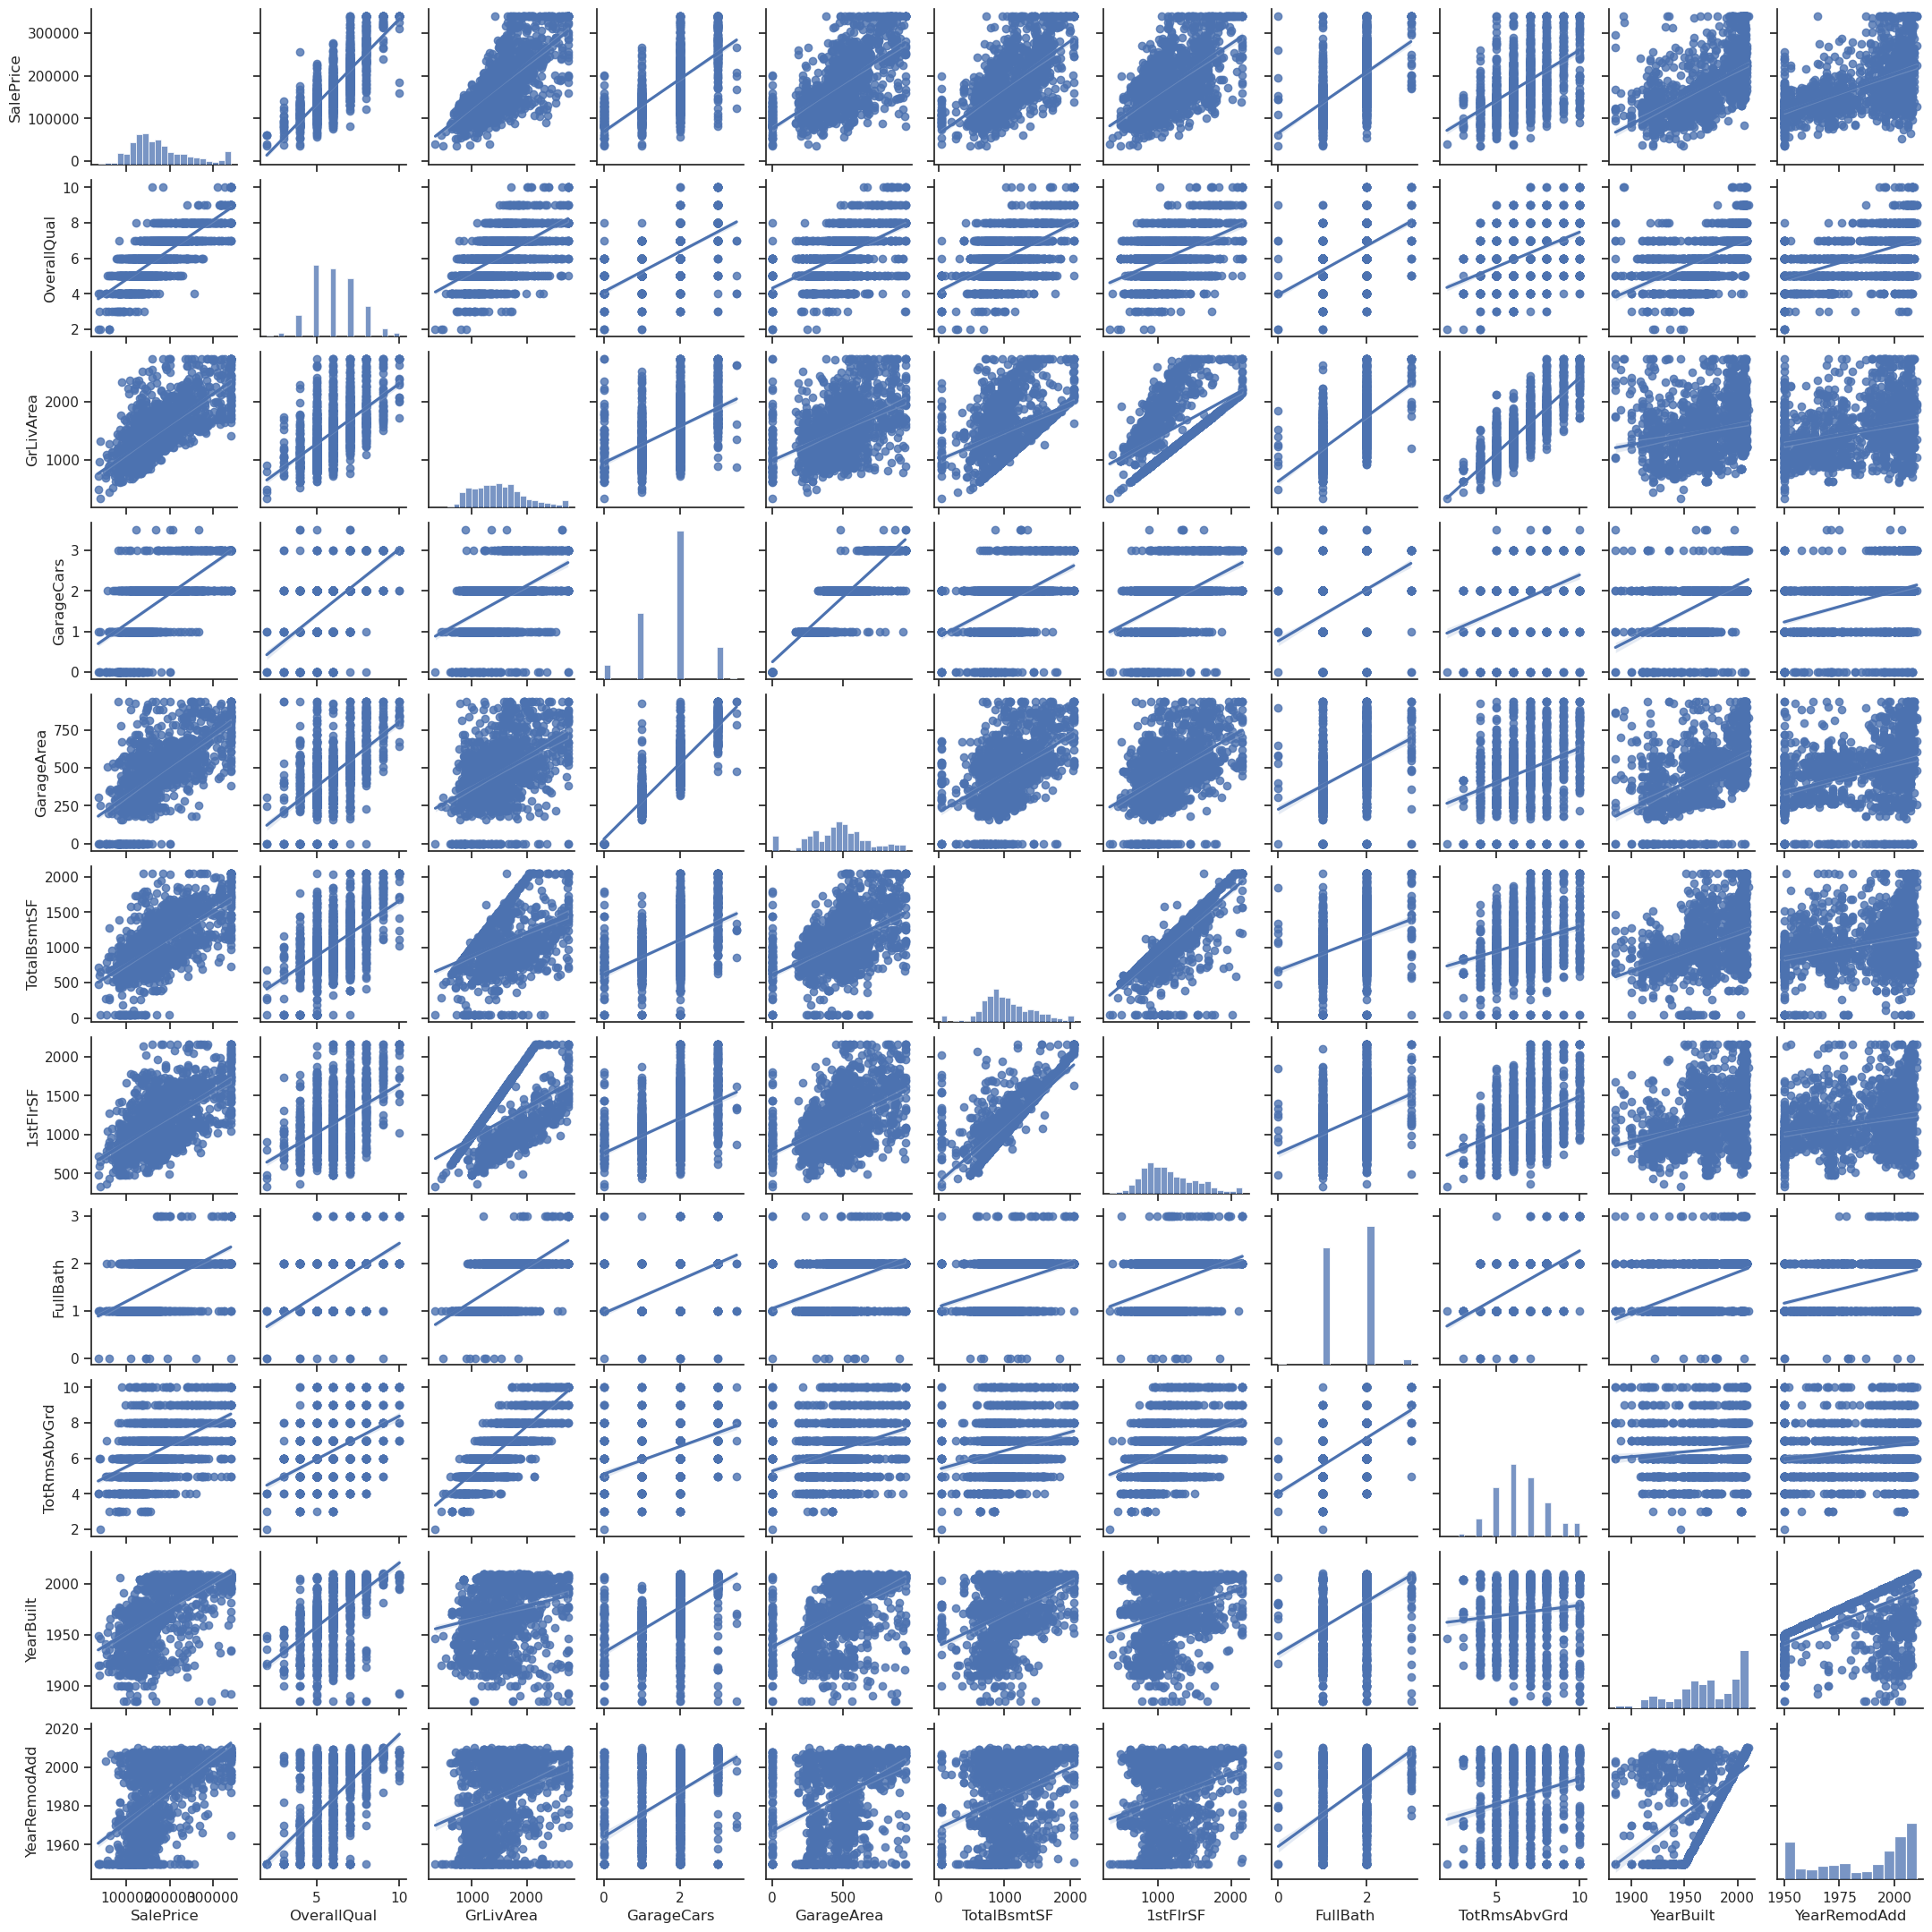

In [43]:
sns.set(style='ticks')
sns.pairplot(train[col], size=2, kind='reg')

In [44]:
train[col].replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

SalePrice  OverallQual  GrLivArea  GarageCars  GarageArea  TotalBsmtSF  \
0      208500.0            7     1710.0         2.0       548.0          856   
1      181500.0            6     1262.0         2.0       460.0         1262   
2      223500.0            7     1786.0         2.0       608.0          920   
3      140000.0            7     1717.0         3.0       642.0          756   
4      250000.0            8     2198.0         3.0       836.0         1145   
...         ...          ...        ...         ...         ...          ...   
1455   175000.0            6     1647.0         2.0       460.0          953   
1456   210000.0            6     2073.0         2.0       500.0         1542   
1457   266500.0            7     2340.0         1.0       252.0         1152   
1458   142125.0            5     1078.0         1.0       240.0         1078   
1459   147500.0            5     1256.0         1.0       276.0         1256   

      1stFlrSF  FullBath  TotRmsAbvGrd  YearBuilt  YearRemodAdd  
0        856.0       2.0             8       2003        2003.0  
1       1262.0       2.0             6       1976        1976.0  
2        920.0       2.0             6       2001        2002.0  
3        961.0       1.0             7       1915        1970.0  
4       1145.0       2.0             9       2000        2000.0  
...        ...       ...           ...        ...           ...  
1455     953.0       2.0             7       1999        2000.0  
1456    2073.0       2.0             7       1978        1988.0  
1457    1188.0       2.0             9       1941        2006.0  
1458    1078.0       1.0             5       1950        1996.0  
1459    1256.0       1.0             6       1965        1965.0  

[1460 rows x 11 columns]

In [45]:
train[col].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SalePrice     1460 non-null   float64
 1   OverallQual   1460 non-null   int64  
 2   GrLivArea     1460 non-null   float64
 3   GarageCars    1460 non-null   float64
 4   GarageArea    1460 non-null   float64
 5   TotalBsmtSF   1460 non-null   int64  
 6   1stFlrSF      1460 non-null   float64
 7   FullBath      1460 non-null   float64
 8   TotRmsAbvGrd  1460 non-null   int64  
 9   YearBuilt     1460 non-null   int64  
 10  YearRemodAdd  1460 non-null   float64
dtypes: float64(7), int64(4)
memory usage: 125.6 KB


In [46]:
train[col].isnull().sum()

SalePrice       0
OverallQual     0
GrLivArea       0
GarageCars      0
GarageArea      0
TotalBsmtSF     0
1stFlrSF        0
FullBath        0
TotRmsAbvGrd    0
YearBuilt       0
YearRemodAdd    0
dtype: int64

In [47]:
# train = train[col].fillna(int(0))
# train.info()

In [48]:
# Isnull = miss_col_train.to_frame()
#Isnull.columns = ['count']
# Isnull.index.names = ['Name']
# Isnull['Name'] = Isnull.index

# plt.figure(figsize=(13, 5))
# sns.set(style='whitegrid')
# sns.barplot(x='Name', y='count', data=Isnull)
# plt.xticks(rotation = 90)
# plt.show()

In [49]:
print(train[col].duplicated().sum())

train[col].drop_duplicates(inplace=True)

0


/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


# Split and Normalize Data

In [50]:
from matplotlib import legend
# Function for evaluation metric for regression
def EvaluationMetric(Xt,yt,yp,disp="on"):
    ''' Take the different set of parameter and prints evaluation metrics '''
    MSE=round(mean_squared_error(y_true=yt,y_pred=yp),4)
    RMSE=(np.sqrt(MSE))
    R2=(r2_score(y_true=yt,y_pred=yp))
    Adjusted_R2=(1-(1-r2_score(yt, yp))*((Xt.shape[0]-1)/(Xt.shape[0]-Xt.shape[1]-1)))
    if disp=="on":
        print("MSE :",MSE,"RMSE :", RMSE)
        print("R2 :",R2,"Adjusted R2 :",Adjusted_R2)
    
    #Plotting Actual and Predicted Values
    plt.figure(figsize=(18,6))
    plt.plot((yp)[:100]) 
    plt.plot((np.array(yt)[:100]))
    plt.legend(["Predicted","Actual"])
    plt.title('Actual and Predicted Time Duration')
    
    return (MSE,RMSE,R2,Adjusted_R2) 

In [51]:
# important_num_cols = list(train.corr()["SalePrice"][(train.corr()["SalePrice"] > 0.5) | (train.corr()["SalePrice"]<-0.5)].index)

# numcols = train[train.columns.intersection(important_num_cols)]
# numcols.head()

In [52]:
X = numcols.drop('SalePrice', axis=1)
y = numcols['SalePrice']

In [53]:
X = pd.DataFrame(X)
X.head()

OverallQual  YearBuilt  YearRemodAdd  TotalBsmtSF  1stFlrSF  GrLivArea  \
0            7       2003        2003.0          856     856.0     1710.0   
1            6       1976        1976.0         1262    1262.0     1262.0   
2            7       2001        2002.0          920     920.0     1786.0   
3            7       1915        1970.0          756     961.0     1717.0   
4            8       2000        2000.0         1145    1145.0     2198.0   

   FullBath  TotRmsAbvGrd  GarageYrBlt  GarageCars  GarageArea  
0       2.0             8       2003.0         2.0       548.0  
1       2.0             6       1976.0         2.0       460.0  
2       2.0             6       2001.0         2.0       608.0  
3       1.0             7       1998.0         3.0       642.0  
4       2.0             9       2000.0         3.0       836.0

In [54]:
# Train Test Split Data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [55]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [56]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1168, 11)
(292, 11)
(1168,)
(292,)


# Regression models

## Linear Regression

In [57]:
# Instance the linear regression object
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train, y_train)

0.8372492290972215

In [58]:
y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)

#### Evaluation metrics for Train set

MSE : 718694282.3935 RMSE : 26808.474078050396
R2 : 0.8372492290972215 Adjusted R2 : 0.8357005625920912


(718694282.3935, 26808.474078050396, 0.8372492290972215, 0.8357005625920912)

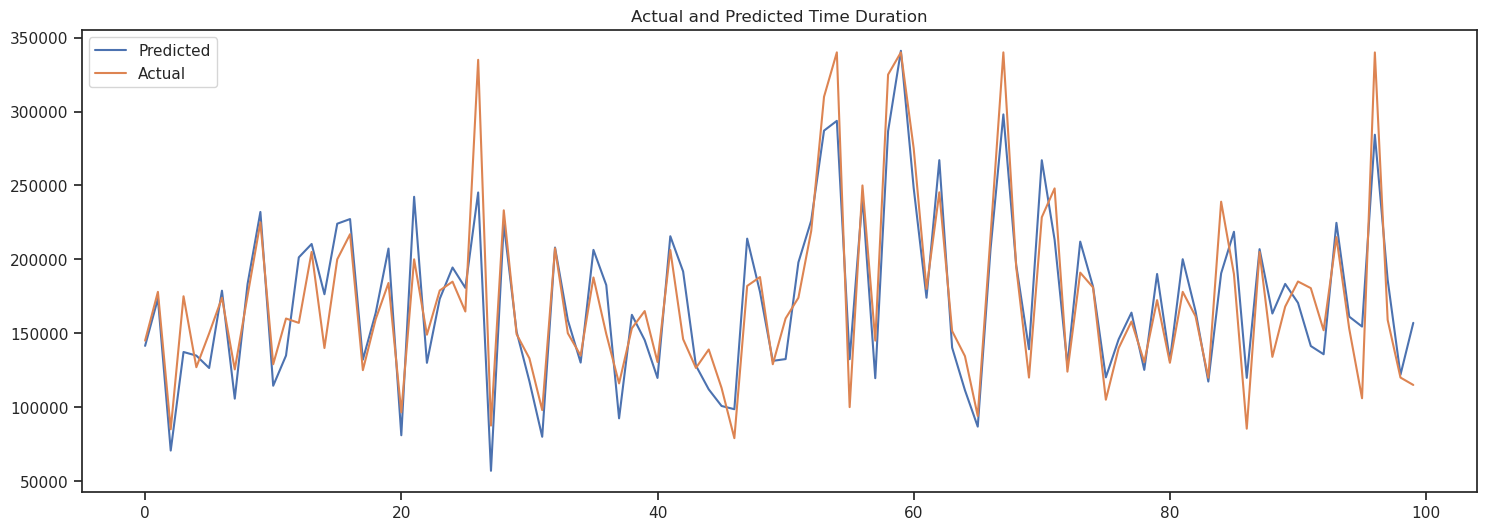

In [59]:
EvaluationMetric(X_train,y_train,y_pred_train)

#### Evaluation metrics for Test set

MSE : 613642848.5169 RMSE : 24771.815608002977
R2 : 0.8744914143447468 Adjusted R2 : 0.8695607199082904


(613642848.5169, 24771.815608002977, 0.8744914143447468, 0.8695607199082904)

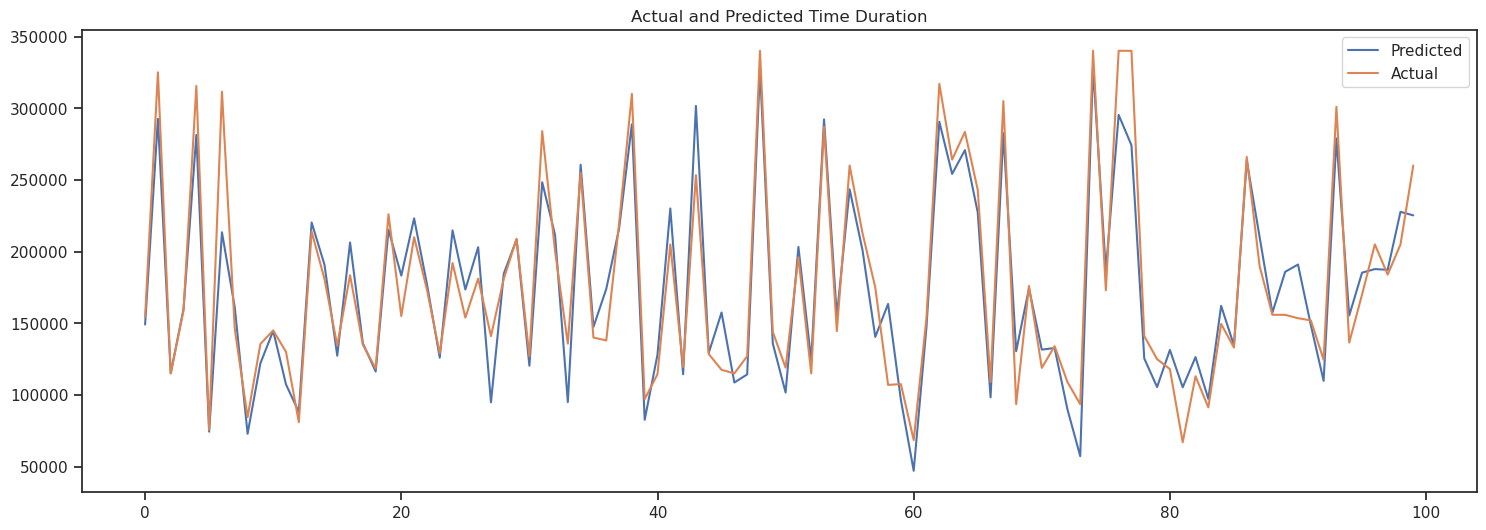

In [60]:
EvaluationMetric(X_test,y_test,y_pred_test)

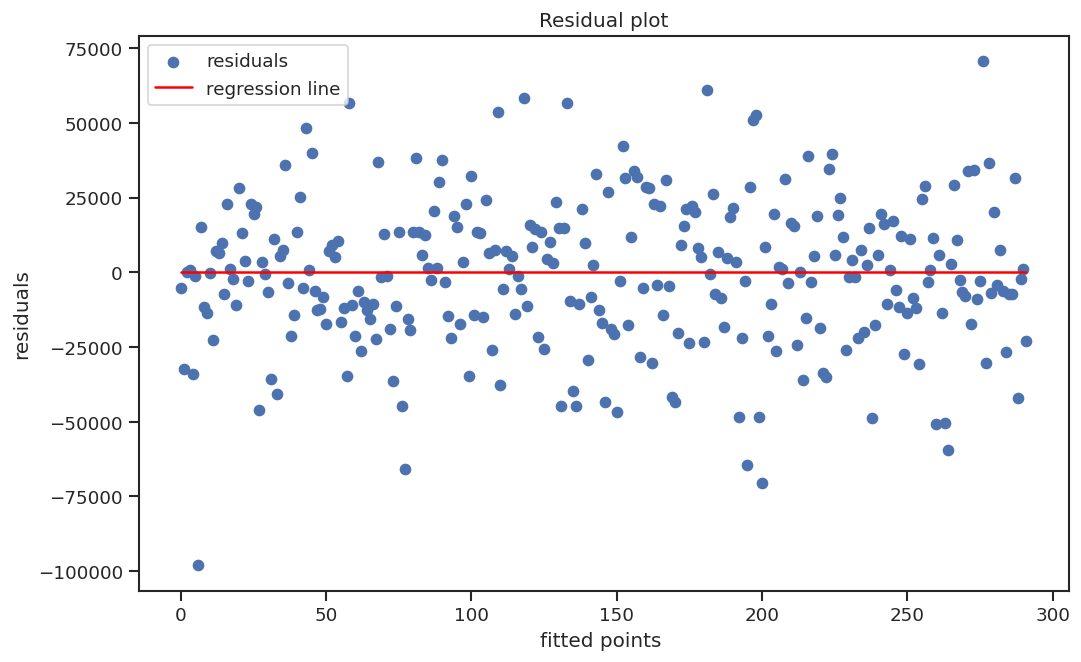

In [61]:
residuals=y_pred_test-y_test

plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='b')
f = range(0,len(y_test))
k = [0 for i in range(0,len(y_test))]
plt.scatter( f, residuals, label = 'residuals')
plt.plot( f, k , color = 'red', label = 'regression line' )
plt.xlabel('fitted points ')
plt.ylabel('residuals')
plt.title('Residual plot')
plt.legend()

## LightGBM

In [62]:
n_estimator=[5,10,20] # No. of tree
max_depth=[5,7,9] # max depth of tree
min_samples_split=[40,50]

params={"n_estimator":n_estimator,
        "max_depth":max_depth,
        "min_samples_split":min_samples_split}

lgb = LGBMRegressor()
gs_lgb = GridSearchCV(lgb,params,cv=3,verbose=2,scoring='r2')
gs_lgb.fit(X_train,y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END ...max_depth=5, min_samples_split=40, n_estimator=5; total time=   0.2s
[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END ...max_depth=5, min_samples_split=40, n_estimator=5; total time=   0.2s
[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END ...max_depth=5, min_samples_split=40, n_estimator=5; total time=   0.2s
[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END ..max_depth=5, min_samples_split=40, n_estimator=10; total time=   0.2s
[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END ..max_depth=5, min_samples_split=40, n_estimator=10; tot

GridSearchCV(cv=3, estimator=LGBMRegressor(),
             param_grid={'max_depth': [5, 7, 9], 'min_samples_split': [40, 50],
                         'n_estimator': [5, 10, 20]},
             scoring='r2', verbose=2)

In [63]:
print(gs_lgb.best_score_)
print(gs_lgb.best_params_)

0.8438787520625533
{'max_depth': 5, 'min_samples_split': 40, 'n_estimator': 5}


In [64]:
gs_lgb.best_estimator_

LGBMRegressor(max_depth=5, min_samples_split=40, n_estimator=5)

In [65]:
gs_lgb_opt_model = gs_lgb.best_estimator_

In [66]:
y_preds_lgb_test = gs_lgb_opt_model.predict(X_test)
y_pred_lgb_train = gs_lgb_opt_model.predict(X_train)

MSE : 310007564.8034 RMSE : 17607.031686329185
R2 : 0.9297977298644772 Adjusted R2 : 0.9291297151832568


(310007564.8034, 17607.031686329185, 0.9297977298644772, 0.9291297151832568)

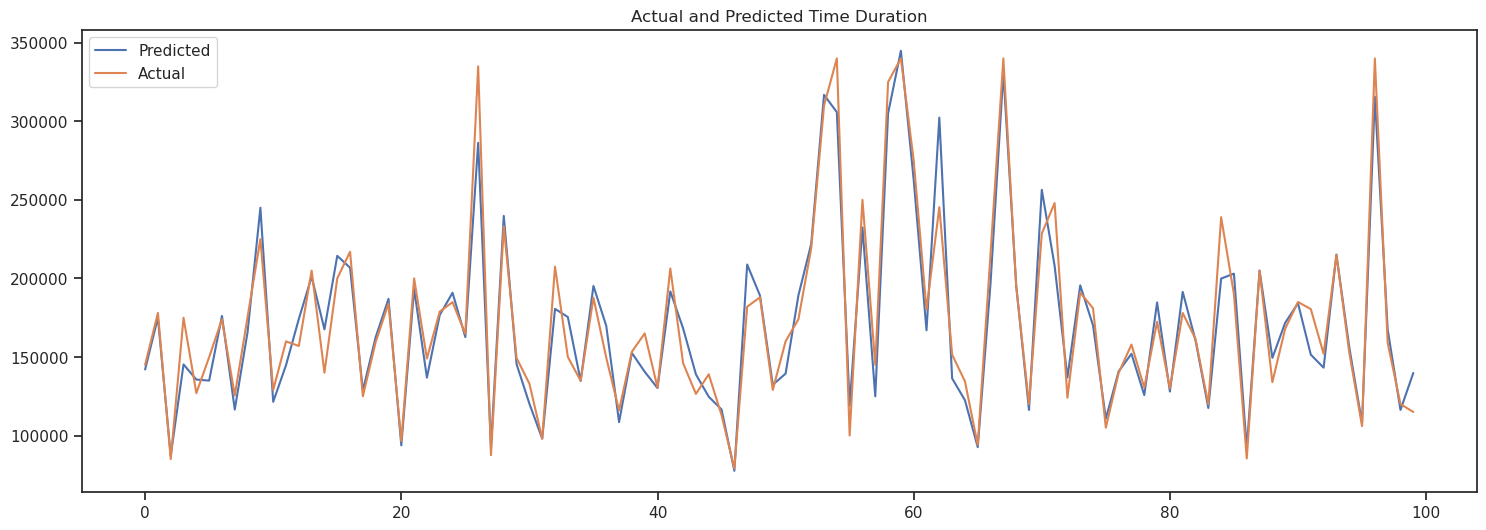

In [67]:
#Evaluation metrics for Train set
EvaluationMetric(X_train,y_train,y_pred_lgb_train)

MSE : 533617354.0724 RMSE : 23100.159178507838
R2 : 0.8908590566115323 Adjusted R2 : 0.8865713766926997


(533617354.0724, 23100.159178507838, 0.8908590566115323, 0.8865713766926997)

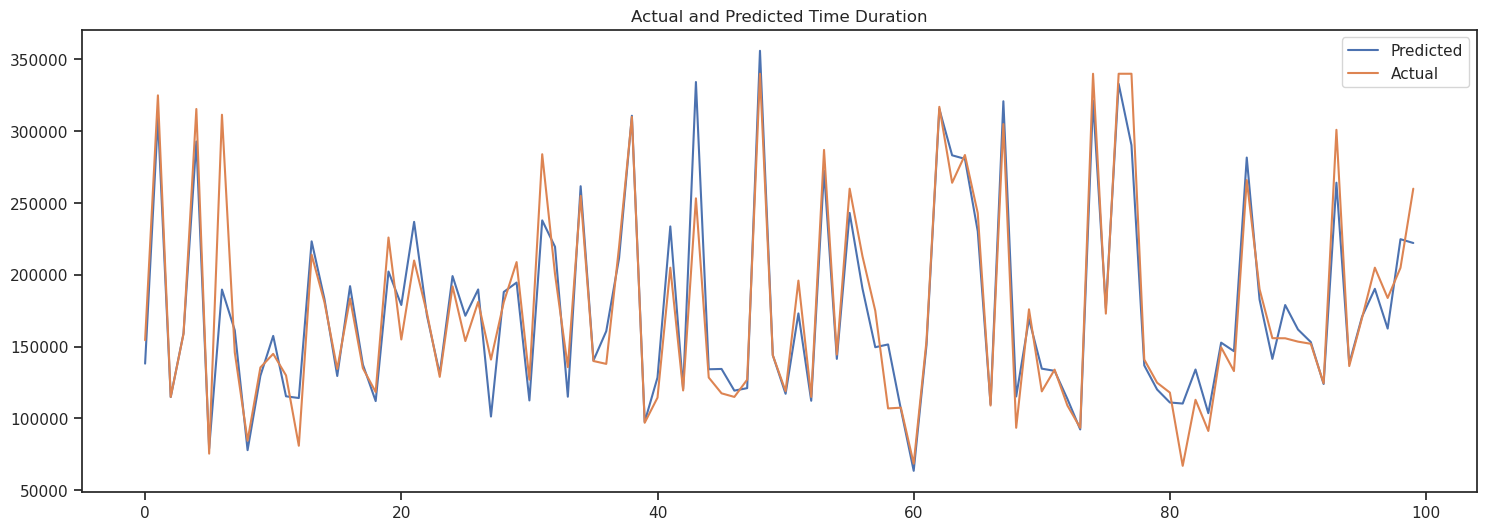

In [68]:
EvaluationMetric(X_test, y_test, y_preds_lgb_test)

In [69]:
# best_estimator

lgb_best = LGBMRegressor(max_depth=9, 
                         min_samples_split=40, 
                         n_estimator=5)

In [70]:
lgb_best.fit(X_train,y_train)


[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] Unknown parameter: min_samples_split


LGBMRegressor(max_depth=9, min_samples_split=40, n_estimator=5)

In [71]:
y_pred_best = lgb_best.predict(X_test)
r2_score(y_test,y_pred_best)

0.8940931601046972

In [72]:
importances = gs_lgb_opt_model.feature_importances_

importance_dict = {'Feature' : list(X.columns),
                   'Feature Importance' : importances}

importance_df = pd.DataFrame(importance_dict)

importance_df.sort_values(by=['Feature Importance'],ascending=False,inplace=True)
importance_df

Feature  Feature Importance
5      GrLivArea                 251
4       1stFlrSF                 174
10    GarageArea                 171
3    TotalBsmtSF                 159
1      YearBuilt                 109
0    OverallQual                  97
2   YearRemodAdd                  84
8    GarageYrBlt                  73
7   TotRmsAbvGrd                  41
9     GarageCars                  37
6       FullBath                   9

<AxesSubplot:title={'center':'Top 10 Features'}, xlabel='Feature', ylabel='Feature Importance'>

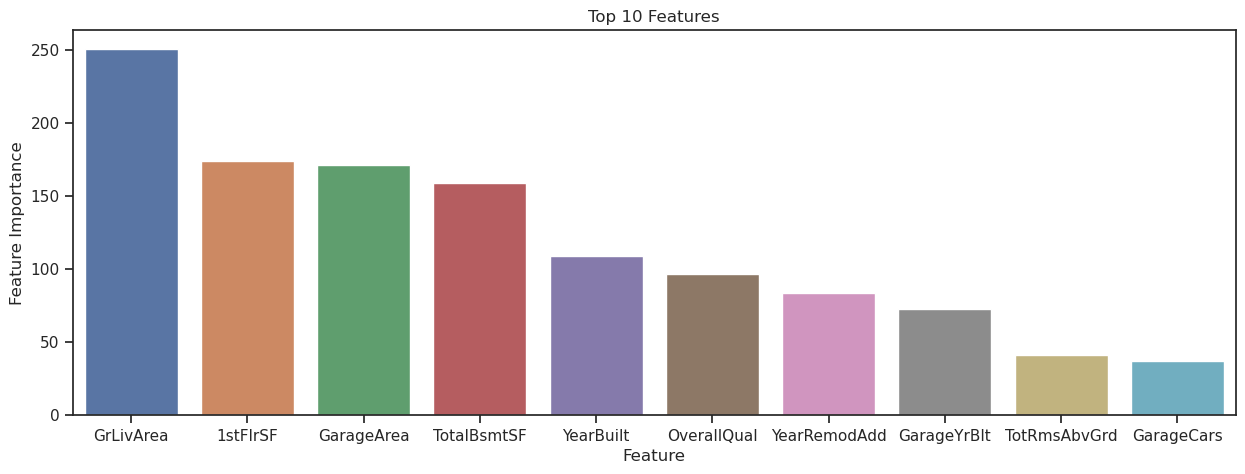

In [73]:
plt.figure(figsize=(15,5))
plt.title('Top 10 Features')
sns.barplot(x='Feature',y="Feature Importance",data=importance_df[:10])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


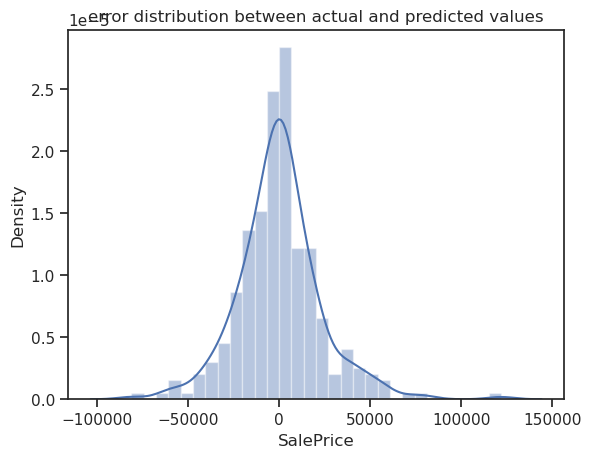

In [74]:
sns.distplot(y_test - y_preds_lgb_test ).set_title("error distribution between actual and predicted values")
plt.show()

## Random Forest 

In [75]:
rf_reg = RandomForestRegressor(random_state=7)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=7)

In [76]:
y_pred = rf_reg.predict(X_test)
r2_score(y_pred,y_test)

0.8631882811053195

In [77]:
n_estimators = [90,100]
max_depth = (1,7,1)
min_samples_leaf = (1,7,1)
min_samples_split = (1,7,1)
max_features = ['auto','log2']

param = {
    "n_estimators" : n_estimators,
    'max_depth' : max_depth,
    'min_samples_leaf' : min_samples_leaf,
    'min_samples_split': min_samples_split,
    'max_features' : max_features
}
rf_grid = GridSearchCV(rf_reg,param)
rf_grid.fit(X_train,y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
360 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
360 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.7/site-packages/joblib/p

GridSearchCV(estimator=RandomForestRegressor(random_state=7),
             param_grid={'max_depth': (1, 7, 1),
                         'max_features': ['auto', 'log2'],
                         'min_samples_leaf': (1, 7, 1),
                         'min_samples_split': (1, 7, 1),
                         'n_estimators': [90, 100]})

In [78]:
print(rf_grid.best_score_)
print(rf_grid.best_params_)

0.8426283692722105
{'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 100}


In [79]:
rf_grid.best_estimator_

RandomForestRegressor(max_depth=7, max_features='log2', min_samples_split=7,
                      random_state=7)

In [80]:
gs_rf_opt_model = rf_grid.best_estimator_

In [81]:
y_preds_rf_test = gs_lgb_opt_model.predict(X_test)
y_pred_rf_train = gs_lgb_opt_model.predict(X_train)

MSE : 310007564.8034 RMSE : 17607.031686329185
R2 : 0.9297977298644772 Adjusted R2 : 0.9291297151832568


(310007564.8034, 17607.031686329185, 0.9297977298644772, 0.9291297151832568)

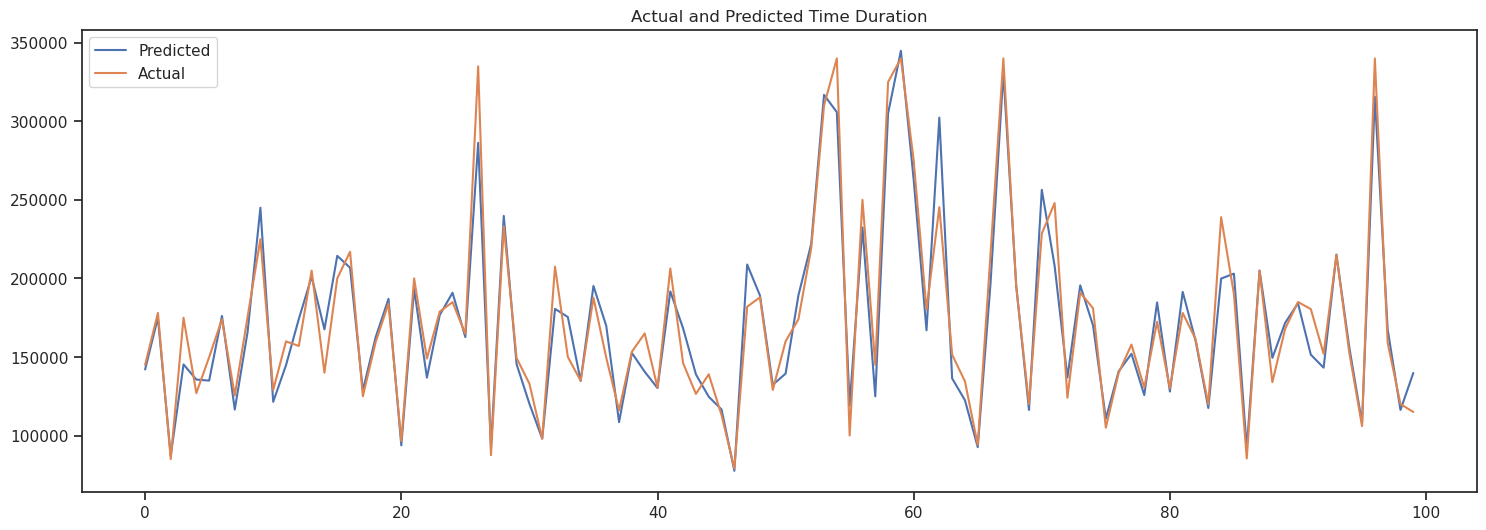

In [82]:
#Evaluation metrics for Train set
EvaluationMetric(X_train,y_train,y_pred_rf_train)

MSE : 533617354.0724 RMSE : 23100.159178507838
R2 : 0.8908590566115323 Adjusted R2 : 0.8865713766926997


(533617354.0724, 23100.159178507838, 0.8908590566115323, 0.8865713766926997)

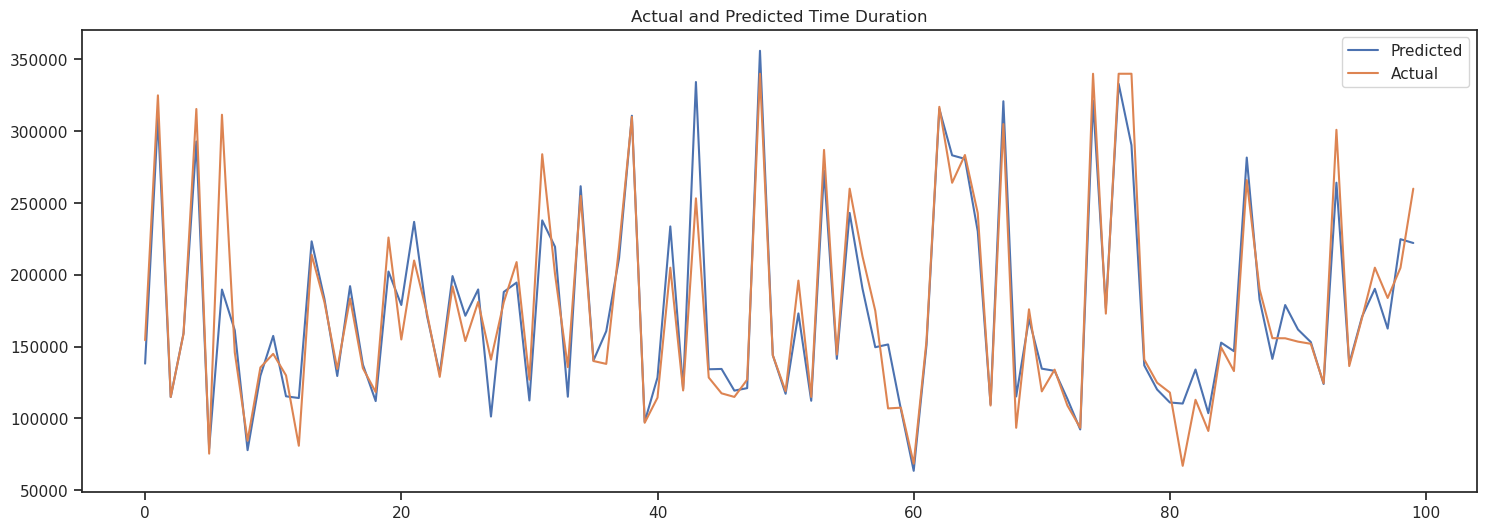

In [83]:
EvaluationMetric(X_test, y_test, y_preds_rf_test)

In [84]:
rf_best = RandomForestRegressor(max_depth=7, max_features='log2', min_samples_leaf=7,
                      min_samples_split=7, random_state=7)

In [85]:
rf_best.fit(X_train,y_train)


RandomForestRegressor(max_depth=7, max_features='log2', min_samples_leaf=7,
                      min_samples_split=7, random_state=7)

In [86]:
y_pred_best = rf_best.predict(X_test)
r2_score(y_test,y_pred_best)

0.8815423203429829

In [87]:
importances = rf_best.feature_importances_

importance_dict = {'Feature' : list(X.columns),
                   'Feature Importance' : importances}

importance_df = pd.DataFrame(importance_dict)

importance_df.sort_values(by=['Feature Importance'],ascending=False,inplace=True)
importance_df

Feature  Feature Importance
0    OverallQual            0.270342
5      GrLivArea            0.198170
1      YearBuilt            0.123799
3    TotalBsmtSF            0.088364
9     GarageCars            0.078653
10    GarageArea            0.063603
4       1stFlrSF            0.051752
8    GarageYrBlt            0.049631
6       FullBath            0.032201
2   YearRemodAdd            0.027126
7   TotRmsAbvGrd            0.016358

<AxesSubplot:title={'center':'Top 10 Features'}, xlabel='Feature', ylabel='Feature Importance'>

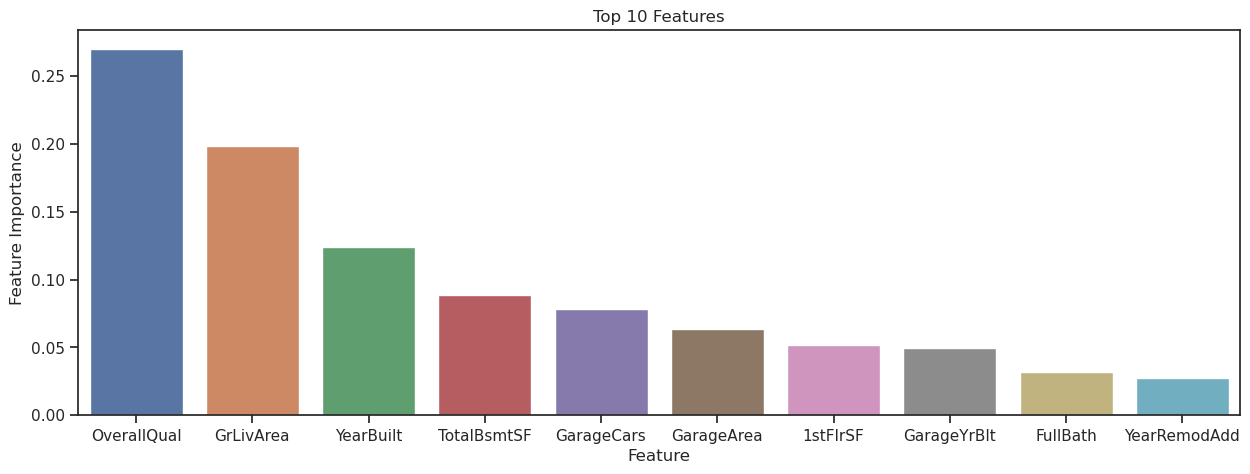

In [88]:
plt.figure(figsize=(15,5))
plt.title('Top 10 Features')
sns.barplot(x='Feature',y="Feature Importance",data=importance_df[:10])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


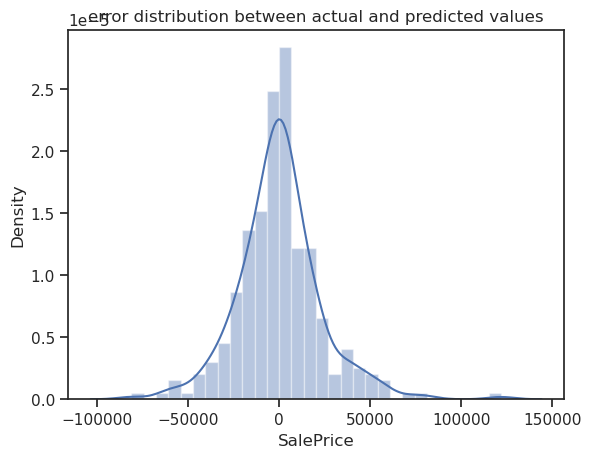

In [89]:
sns.distplot(y_test - y_preds_rf_test).set_title("error distribution between actual and predicted values")
plt.show()

# test data and Submission

In [90]:
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
test.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   
4  1465         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub  ...         120        0    NaN  MnPrv         NaN   
1         Lvl    AllPub  ...           0        0    NaN    NaN        Gar2   
2         Lvl    AllPub  ...           0        0    NaN  MnPrv         NaN   
3         Lvl    AllPub  ...           0        0    NaN    NaN         NaN   
4         HLS    AllPub  ...         144        0    NaN    NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  
0       0      6    2010        WD         Normal  
1   12500      6    2010        WD         Normal  
2       0      3    2010        WD         Normal  
3       0      6    2010        WD         Normal  
4       0      1    2010        WD         Normal  

[5 rows x 80 columns]

In [91]:
test.fillna(value=0, inplace=True)

# Replace infinite values with a large finite value or np.nan, and then handle the np.nan values as before
test.replace([np.inf, -np.inf], np.nan, inplace=True)
test.fillna(value=0, inplace=True)

In [92]:
cat_features_test = np.array([i for i in test.columns.tolist() if test[i].dtype == 'object'])
num_features_test = np.array([i for i in test.columns.tolist() if test[i].dtype != 'object'])

In [93]:
replace_with_thresholds(test, num_features_test)

In [94]:
# X_test  = test.select_dtypes(include=['number']).copy()

X_cols = top_feature.copy()
X_test = test[X_cols[1:]]
X_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OverallQual   1459 non-null   int64  
 1   GrLivArea     1459 non-null   float64
 2   GarageCars    1459 non-null   float64
 3   GarageArea    1459 non-null   float64
 4   TotalBsmtSF   1459 non-null   float64
 5   1stFlrSF      1459 non-null   int64  
 6   FullBath      1459 non-null   float64
 7   YearBuilt     1459 non-null   int64  
 8   GarageYrBlt   1459 non-null   float64
 9   YearRemodAdd  1459 non-null   float64
 10  TotRmsAbvGrd  1459 non-null   int64  
dtypes: float64(7), int64(4)
memory usage: 125.5 KB


In [95]:
rf_best = RandomForestRegressor(max_depth=7, max_features='log2', min_samples_leaf=7,
                      min_samples_split=7, random_state=7)
rf_best.fit(X,y)
y_pred = rf_best.predict(X_test)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [96]:
submission = pd.DataFrame({"Id":test.index, "SalePrice":y_pred})
submission.to_csv('submission.csv', index=False)

In [97]:
# predictions = final_model.predict(X_test)

In [98]:
# solution = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')
# y_pred = solution["SalePrice"]

# from sklearn.metrics import mean_squared_log_error
# RMSLE = np.sqrt( mean_squared_log_error(y_pred) )
# print("The score is %.5f" % RMSLE )